# System preparation

## Import libraries

In [2]:
# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
# Data 
import numpy as np
import pandas as pd

#Regular expressions
import re as re

# Utilities
from time import time

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale


from sklearn import model_selection
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline

# Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import make_scorer


# Regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn import ensemble

# Regression linear models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

# Tree models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Support Vector Machine model
from sklearn.svm import SVR

# Gradient Boosting models
import xgboost as xgb
from catboost import CatBoostRegressor

# Others
import warnings
from functools import reduce
from pathlib import Path
import os

#Power Transformations
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


In [3]:
import sys
sys.path.insert(1, '../')

#Regression models
from functions.regression_models import run_cv_reg

In [4]:
# Configurations.
%matplotlib inline
sns.set_style("darkgrid")
warnings.filterwarnings("ignore")
plt.rc("font", family="serif", size=15)

## Defined functions

# 3. PROGNOSTICS

**Prognostics**

    # Prognostics: predicting the time at which something will no longer perform it's indended function
    # Remaining Useful Life (RUL): continious target, number of useful cycles left on the engine

## What is the RUL?

The next step of PdM is prognostics. Here, the goal is to predict the monitored system's future state and estimate the system’s remaining useful life (RUL), i.e., how long it will take until system failure occurs.

<p align="center">
  <img width="400" height="300" src="https://miro.medium.com/max/1124/1*zChVbvqk7pKdEA0PZpCjUQ.png">
</p>


The following figure 3 shows the Predictive Maintenance Pipeline for Model Selection. Here, only dark colored steps of the pipelines are used.

![](https://drive.google.com/uc?export=view&id=1baeSPqyrno0mkdJM423my9R4I2e6D7Mn)

# Regression

## Load data



Read the csv with the feature engineering applied before to the raw data.

In [5]:
compressors_all_data = pd.read_csv("../data/compressors_all_data_best_features_2days.csv", error_bad_lines=False, index_col=0)

In [30]:
#Make sure the datetime format is correct
compressors_all_data["datetime"] = pd.to_datetime(compressors_all_data["datetime"], format="%Y-%m-%d %H:%M:%S")

In [31]:
compressors_all_data.head()

,compressorID,datetime,cycle,current_mean_3h,rpm_mean_3h,pressure_mean_3h,vibration_mean_3h,current_mean_lag_24h,rpm_mean_lag_24h,pressure_mean_lag_24h,...,s-8760,c-8760,comp1_fail,comp2_fail,comp3_fail,comp4_fail,rul_comp1,rul_comp2,rul_comp3,rul_comp4
0,1,2015-01-01 09:00:00,1,170.028993,449.533798,94.592122,40.893502,NaN,NaN,NaN,...,0.000000,1.000000,0.0,0.0,0.0,0.0,63.875,108.875,NaN,3.875
1,1,2015-01-01 12:00:00,2,164.192565,403.949857,105.687417,34.255891,NaN,NaN,NaN,...,0.002152,0.999998,0.0,0.0,0.0,0.0,63.750,108.750,NaN,3.750
2,1,2015-01-01 15:00:00,3,168.134445,435.781707,107.793709,41.239405,NaN,NaN,NaN,...,0.004304,0.999991,0.0,0.0,0.0,0.0,63.625,108.625,NaN,3.625
3,1,2015-01-01 18:00:00,4,165.514453,430.472823,101.703289,40.373739,NaN,NaN,NaN,...,0.006455,0.999979,0.0,0.0,0.0,0.0,63.500,108.500,NaN,3.500
4,1,2015-01-01 21:00:00,5,168.809347,437.111120,90.911060,41.738542,NaN,NaN,NaN,...,0.008607,0.999963,0.0,0.0,0.0,0.0,63.375,108.375,NaN,3.375


Create lists with the names of the columns for different data:
- Sensors: telemetry information
- Errors: compressor errors and counts
- Maintenance: time since last maintenance
- Model
- Compressor information: Age
- Failures: failures in the different components

In [32]:
print(compressors_all_data.shape)


(292100, 51)


In [33]:
print(compressors_all_data.isnull().any())

compressorID              False
datetime                  False
cycle                     False
current_mean_3h           False
rpm_mean_3h               False
pressure_mean_3h          False
vibration_mean_3h         False
current_mean_lag_24h       True
rpm_mean_lag_24h           True
pressure_mean_lag_24h      True
vibration_mean_lag_24h     True
current_max_lag_24h        True
rpm_max_lag_24h            True
pressure_max_lag_24h       True
vibration_max_lag_24h      True
current_min_lag_24h        True
rpm_min_lag_24h            True
pressure_min_lag_24h       True
vibration_min_lag_24h      True
error1                    False
error2                    False
error3                    False
error4                    False
error5                    False
error1count               False
error2count               False
error3count               False
error4count               False
error5count               False
comp1_maint               False
comp2_maint               False
comp3_ma

In [34]:
print(compressors_all_data.dtypes)

compressorID                       int64
datetime                  datetime64[ns]
cycle                              int64
current_mean_3h                  float64
rpm_mean_3h                      float64
pressure_mean_3h                 float64
vibration_mean_3h                float64
current_mean_lag_24h             float64
rpm_mean_lag_24h                 float64
pressure_mean_lag_24h            float64
vibration_mean_lag_24h           float64
current_max_lag_24h              float64
rpm_max_lag_24h                  float64
pressure_max_lag_24h             float64
vibration_max_lag_24h            float64
current_min_lag_24h              float64
rpm_min_lag_24h                  float64
pressure_min_lag_24h             float64
vibration_min_lag_24h            float64
error1                           float64
error2                           float64
error3                           float64
error4                           float64
error5                           float64
error1count     

In [35]:
compressors_all_data.error1 = compressors_all_data.error1.astype(int)
compressors_all_data.error2 = compressors_all_data.error2.astype(int)
compressors_all_data.error3 = compressors_all_data.error3.astype(int)
compressors_all_data.error4 = compressors_all_data.error4.astype(int)
compressors_all_data.error5 = compressors_all_data.error5.astype(int)

In [36]:
compressors_all_data.error1count = compressors_all_data.error1count.astype(int)
compressors_all_data.error2count = compressors_all_data.error2count.astype(int)
compressors_all_data.error3count = compressors_all_data.error3count.astype(int)
compressors_all_data.error4count = compressors_all_data.error4count.astype(int)
compressors_all_data.error5count = compressors_all_data.error5count.astype(int)


## Features selection

Feature selection is the process of reducing the number of input variables when developing a predictive model. It is desirable to reduce the number of input variables to both reduce the computational cost of modeling and, in some cases, to improve the performance of the model.

In [37]:
cols_failures_dum = [col for col in compressors_all_data.columns if 'fail' in col]

In [38]:
cols_rul = [col for col in compressors_all_data.columns if 'rul' in col]

In [39]:
cols_seasonality = [col for col in compressors_all_data.columns if (('s-' in col) | ('c-' in col))]

In [40]:
target = cols_rul
target

['rul_comp1', 'rul_comp2', 'rul_comp3', 'rul_comp4']

Drop everything but failures, rul and datetime

In [41]:
predictors = list(compressors_all_data.columns)
predictors = [ele for ele in predictors if ele not in (cols_rul + cols_failures_dum + ['datetime']) ]

## Create datasets

In [42]:
# Drop NA in the predictors
compressors_all_data_rul = compressors_all_data[predictors].dropna().merge(compressors_all_data[target].loc[list(compressors_all_data[predictors].dropna().index)], left_index=True, right_index=True)

X = compressors_all_data_rul[predictors]
y= compressors_all_data_rul[target]

In [43]:
# All the data

y_list = []
X_list = []

for rul_comp in y.columns:
  exec('y_{} = pd.DataFrame()'.format(rul_comp))
  exec('y_{} = y[rul_comp]'.format(rul_comp))
  exec('y_{}.dropna(inplace=True)'.format(rul_comp))
  exec('temp= X.loc[list(y_{}.index)]'.format(rul_comp))
  exec('X_{}= temp'.format(rul_comp))
  exec('y_list.append(str("y_{}"))'.format(rul_comp))
  exec('X_list.append(str("X_{}"))'.format(rul_comp))

## Split into Test and Train

In [44]:
# We establish the times corresponding to the records that will be used for training and tests.
threshold_dates = [
    pd.to_datetime("2015-05-30 01:00:00"), pd.to_datetime("2015-06-01 01:00:00")
]

In [45]:
# We make the partition of separate dates.
last_train_date = threshold_dates[0]
first_test_date = threshold_dates[1]

In [46]:
# Typically 20-30% of the data is used.
ntraining = compressors_all_data.loc[compressors_all_data["datetime"] < last_train_date]
ntesting = compressors_all_data.loc[compressors_all_data["datetime"] > first_test_date]

In [47]:
# Drop NaN from the predictors
ntraining_rul = ntraining[predictors].dropna().merge(ntraining[target].loc[list(ntraining[predictors].dropna().index)], left_index=True, right_index=True)
ntesting_rul = ntesting[predictors].dropna().merge(ntesting[target].loc[list(ntesting[predictors].dropna().index)], left_index=True, right_index=True)

In [48]:
# We assign the corresponding values to training and tests.
y_train = ntraining_rul[target]
X_train = ntraining_rul[predictors]
y_test = ntesting_rul[target] 
X_test = ntesting_rul[predictors]

**Missing data**

It's nedeed to get rid of the missing data, to be able to run the algorithms.

- As first approach drop NaN values

In [49]:
for rul_comp in cols_rul:
  # For the training set
  exec('y_train_{} = pd.DataFrame()'.format(rul_comp))
  exec('y_train_{} = y_train[rul_comp]'.format(rul_comp))
  exec('y_train_{}.dropna(inplace=True)'.format(rul_comp))
  exec('temp= X_train.loc[list(y_train_{}.index)]'.format(rul_comp))
  exec('X_train_{}= temp'.format(rul_comp))

  #For the testing set
  exec('y_test_{} = pd.DataFrame()'.format(rul_comp))
  exec('y_test_{} = y_test[rul_comp]'.format(rul_comp))
  exec('y_test_{}.dropna(inplace=True)'.format(rul_comp))
  exec('temp= X_test.loc[list(y_test_{}.index)]'.format(rul_comp))
  exec('X_test_{}= temp'.format(rul_comp))

# More significative variables 

Picking out the relevant attributes dor regression modelling

The 10 variables which affects the most rul_comp1 positively Index(['rul_comp1', 's-8760', 'model3', 'age', 'c-8760'], dtype='object')



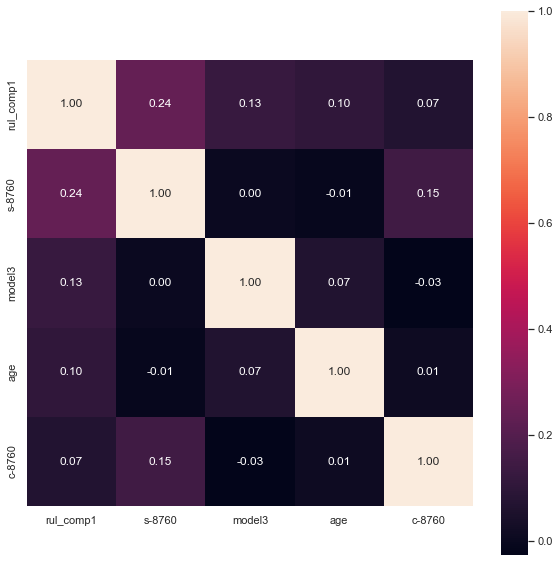


The 10 variables which affects the most rul_comp1 negatively Index(['cycle', 'model2', 'comp1_maint', 'current_mean_lag_24h',
       'current_mean_3h'],
      dtype='object')



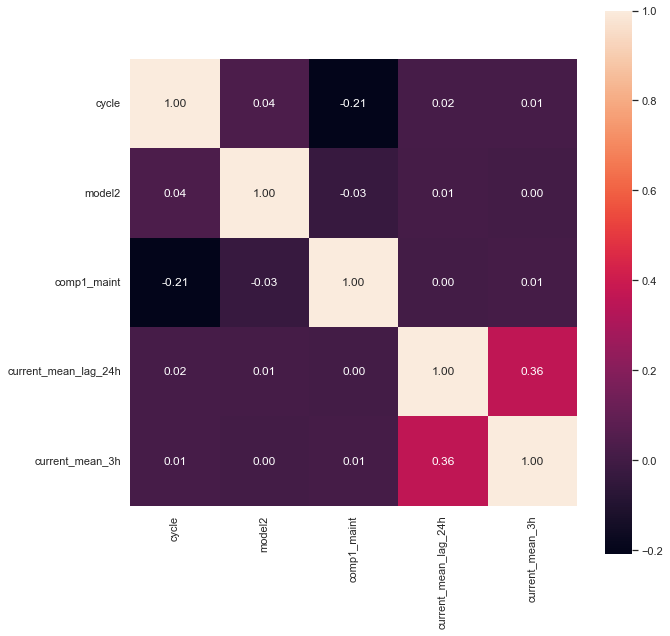


The 10 variables which affects the most rul_comp2 positively Index(['rul_comp2', 's-8760', 'comp3_maint', 'c-8760', 'comp1_maint'], dtype='object')



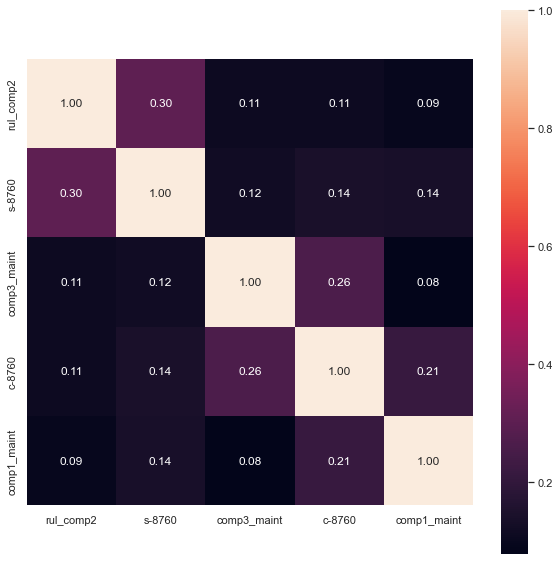


The 10 variables which affects the most rul_comp2 negatively Index(['cycle', 'error3', 'error2', 'vibration_mean_lag_24h',
       'vibration_max_lag_24h'],
      dtype='object')



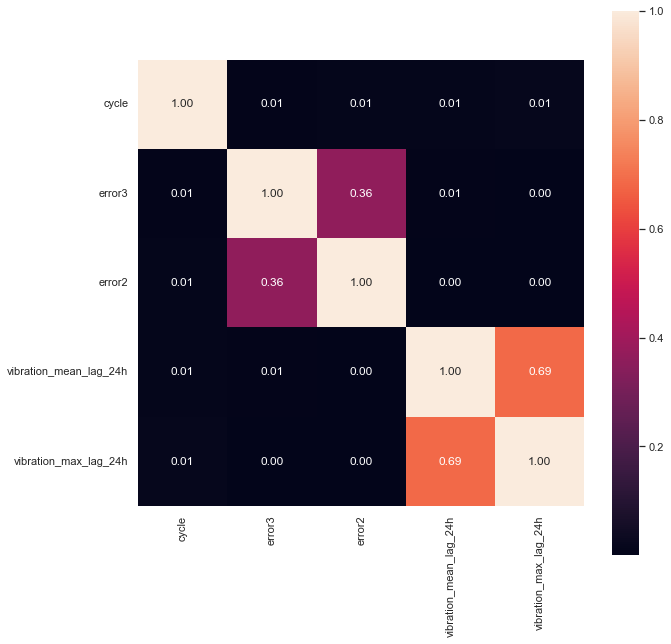


The 10 variables which affects the most rul_comp3 positively Index(['rul_comp3', 's-8760', 'model2', 'comp1_maint', 'comp2_maint'], dtype='object')



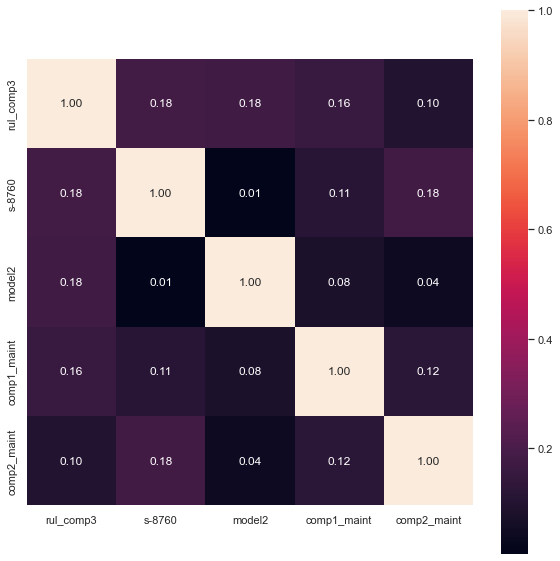


The 10 variables which affects the most rul_comp3 negatively Index(['comp3_maint', 'cycle', 'pressure_mean_3h', 'pressure_mean_lag_24h',
       'compressorID'],
      dtype='object')



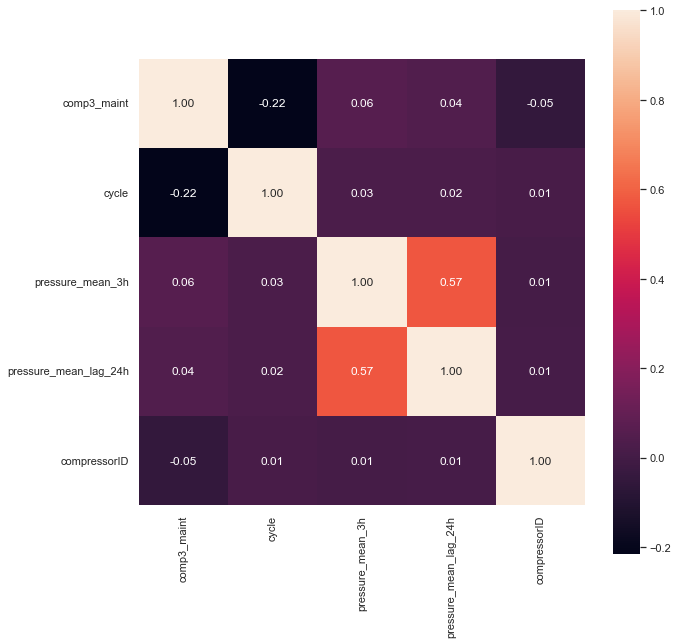


The 10 variables which affects the most rul_comp4 positively Index(['rul_comp4', 's-8760', 'comp3_maint', 'model4', 'error5count'], dtype='object')



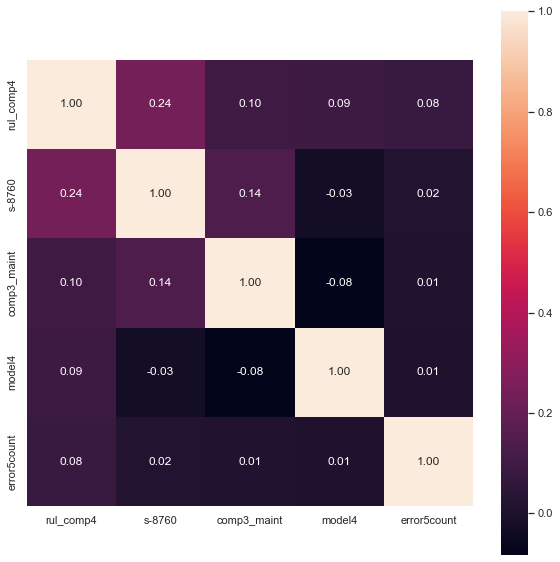


The 10 variables which affects the most rul_comp4 negatively Index(['cycle', 'comp4_maint', 'vibration_mean_3h', 'vibration_mean_lag_24h',
       'model2'],
      dtype='object')



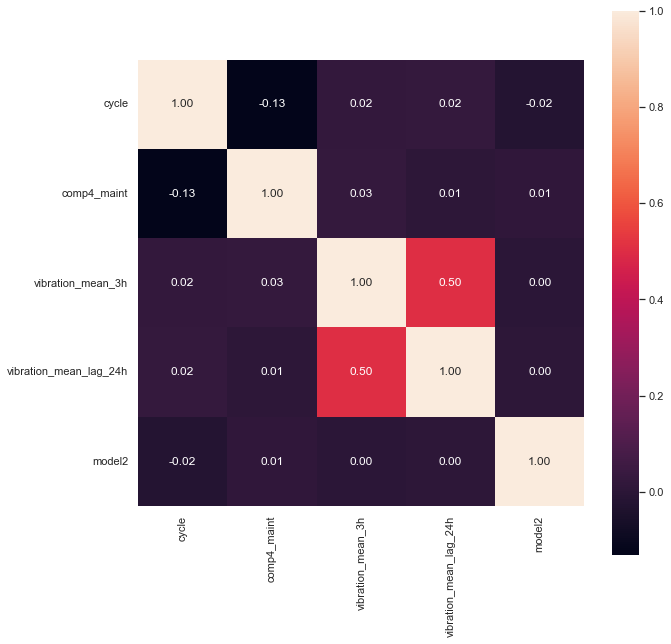

In [50]:
for rul_comp in y.columns:
    exec('y_temp = y_{}'.format(rul_comp))
    exec('X_temp = X_{}'.format(rul_comp))
    temp_data = pd.concat([X_temp, y_temp], axis=1)
    correlation = temp_data.corr(method='pearson')
    columns_max = correlation.nlargest(5, rul_comp).index
    columns_min = correlation.nsmallest(5, rul_comp).index

    print(f'The 10 variables which affects the most {rul_comp} positively {columns_max}')
    print()
    correlation_map = np.corrcoef(temp_data[columns_max].values.T)
    sns.set(font_scale=1.0)
    fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
    heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns_max.values, xticklabels=columns_max.values, ax=ax)
    plt.show()
    print()
    print(f'The 10 variables which affects the most {rul_comp} negatively {columns_min}')
    print()
    correlation_map = np.corrcoef(temp_data[columns_min].values.T)
    sns.set(font_scale=1.0)
    fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
    heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns_min.values, xticklabels=columns_min.values, ax=ax)
    plt.show()
    print()

The outcome at this section is to identify which are the more important features influencing the RUL of each component.

We will run a Random Forest and create an order for the features that most influenced the algorithm.

At first stage, only the variables coming from the sensors will be studied



Create the RandomForest Regressor

In [51]:
# I like to use a simple random forest to determine some of the most important/meaningful features. Can be used as feature selection
# create an exhuastive random forest (200 trees up to 15 levels deep)
rf = ensemble.RandomForestRegressor()
single_rf = ensemble.RandomForestRegressor(n_estimators = 25, max_depth = 5)

#### Only sensor columns

In [52]:
# Define a lagging time period
time_lagged_sensors = 24
# Size of the time window
time_window_resample_hours = 3

In [53]:
cols_sensors_lagged = [col for col in compressors_all_data.columns if ((str(time_lagged_sensors)+'h' in col) and (('mean' in col)|('max' in col)|('min' in col)))]
cols_sensors_window_resample = [col for col in compressors_all_data.columns if (str(time_window_resample_hours)+'h' in col) and ('mean' in col)]
cols_sensors_lagged_mean = [col for col in compressors_all_data.columns if ((str(time_lagged_sensors)+'h' in col) and ('mean' in col))]

cols_sensors_all = cols_sensors_window_resample + cols_sensors_lagged

complete---> rul_comp1



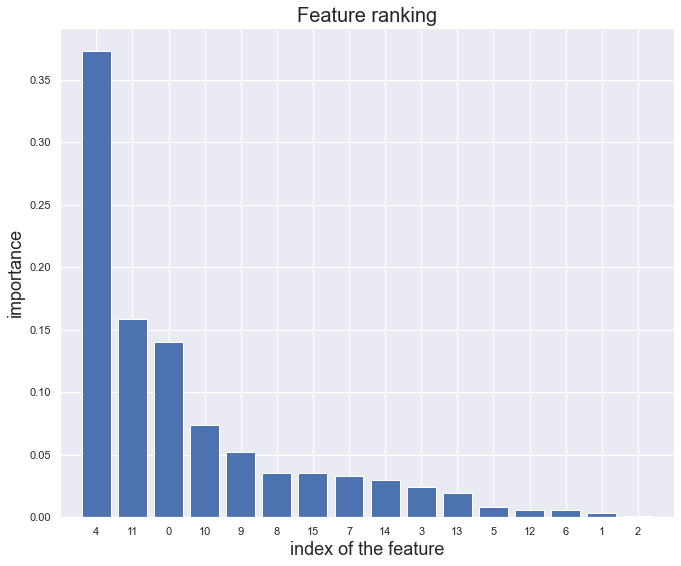

current_mean_lag_24h      0.372721
vibration_max_lag_24h     0.158779
current_mean_3h           0.140448
pressure_max_lag_24h      0.073722
rpm_max_lag_24h           0.052139
current_max_lag_24h       0.035595
vibration_min_lag_24h     0.035372
vibration_mean_lag_24h    0.033356
pressure_min_lag_24h      0.029783
vibration_mean_3h         0.024379
dtype: float64

complete---> rul_comp2



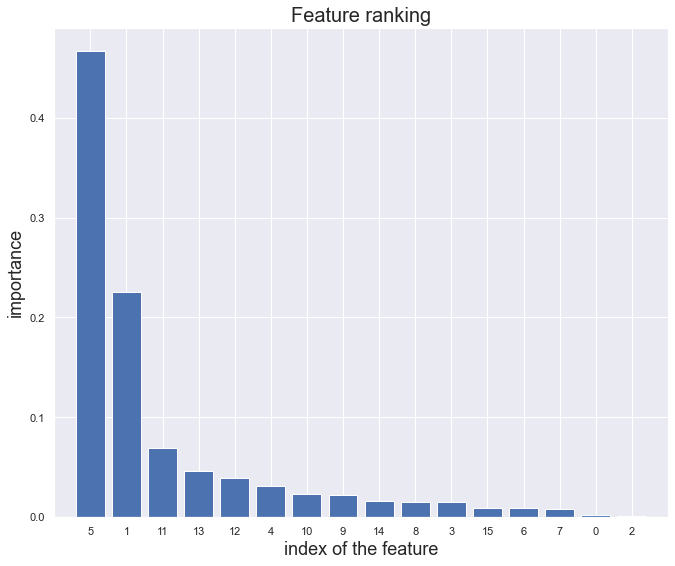

rpm_mean_lag_24h         0.466378
rpm_mean_3h              0.225063
vibration_max_lag_24h    0.069298
rpm_min_lag_24h          0.046213
current_min_lag_24h      0.039693
current_mean_lag_24h     0.031007
pressure_max_lag_24h     0.022950
rpm_max_lag_24h          0.022602
pressure_min_lag_24h     0.016622
current_max_lag_24h      0.015521
dtype: float64

complete---> rul_comp3



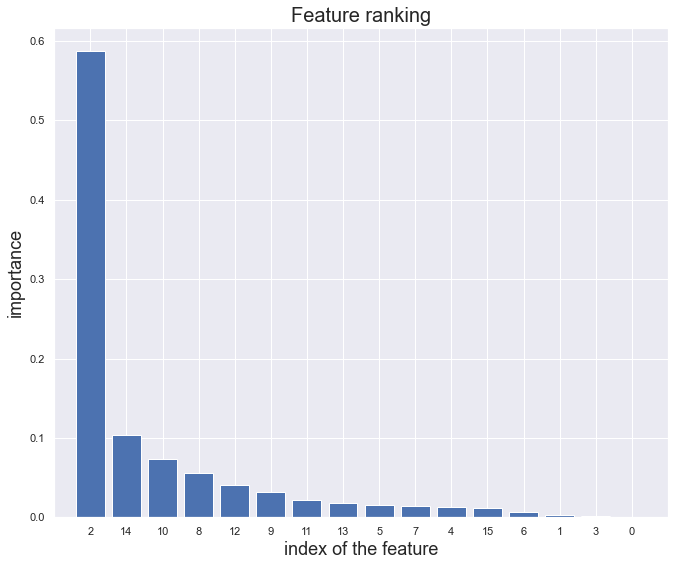

pressure_mean_3h          0.586900
pressure_min_lag_24h      0.103924
pressure_max_lag_24h      0.073264
current_max_lag_24h       0.055960
current_min_lag_24h       0.041013
rpm_max_lag_24h           0.032299
vibration_max_lag_24h     0.021666
rpm_min_lag_24h           0.018534
rpm_mean_lag_24h          0.015848
vibration_mean_lag_24h    0.014045
dtype: float64

complete---> rul_comp4



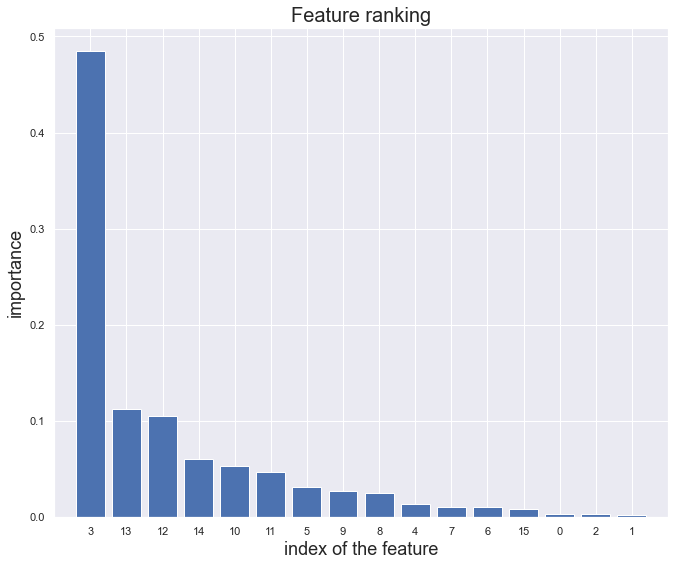

vibration_mean_3h        0.484498
rpm_min_lag_24h          0.112795
current_min_lag_24h      0.105455
pressure_min_lag_24h     0.060380
pressure_max_lag_24h     0.053191
vibration_max_lag_24h    0.047538
rpm_mean_lag_24h         0.032012
rpm_max_lag_24h          0.027229
current_max_lag_24h      0.024995
current_mean_lag_24h     0.013743
dtype: float64



In [54]:
for rul_comp in cols_rul:

  exec('y_temp = y_{}'.format(rul_comp))
  exec('X_temp = X_{}'.format(rul_comp))

  # First approach only with sensors
  X_temp = X_temp[cols_sensors_all]

  single_rf.fit(X_temp, y_temp)
  y_pred = single_rf.predict(X_temp)

  print("complete---> " + rul_comp)
  print()

  # graph feature importance
  importances = single_rf.feature_importances_
  indices = np.argsort(importances)[::-1]
  feature_names = X_temp.columns    

  f, ax = plt.subplots(figsize=(11, 9))
  plt.title("Feature ranking", fontsize = 20)
  plt.bar(range(X_temp.shape[1]), importances[indices], color="b", align="center")
  plt.xticks(range(X_temp.shape[1]), indices) #feature_names, rotation='vertical')
  plt.xlim([-1, X_temp.shape[1]])
  plt.ylabel("importance", fontsize = 18)
  plt.xlabel("index of the feature", fontsize = 18)
  plt.show()

  # list feature importance
  important_features = pd.Series(data=single_rf.feature_importances_,index=X_temp.columns)
  important_features.sort_values(ascending=False,inplace=True)
  print(important_features.head(10))
  print()

#### All columns

In [55]:
rf = ensemble.RandomForestRegressor()
single_rf = ensemble.RandomForestRegressor(n_estimators = 42, max_depth = 5)

complete---> rul_comp1



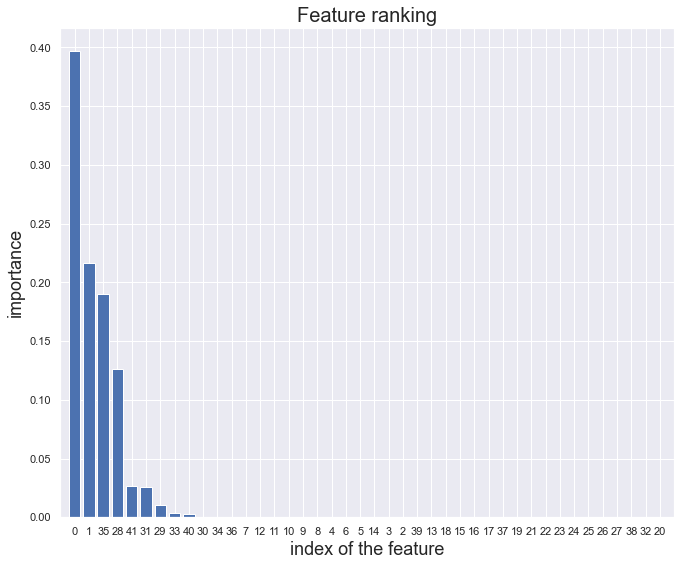

compressorID    0.396689
cycle           0.216092
age             0.190204
comp1_maint     0.126255
c-8760          0.026432
comp4_maint     0.026099
comp2_maint     0.010801
model3          0.003769
s-8760          0.002903
comp3_maint     0.000420
dtype: float64

complete---> rul_comp2



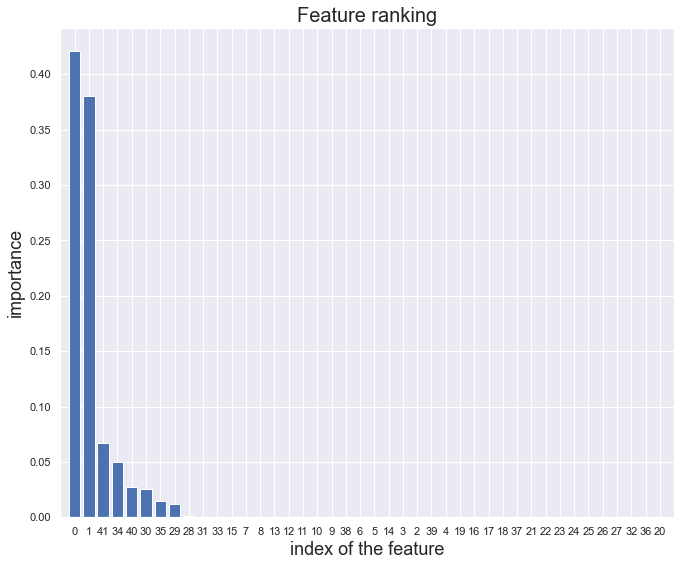

compressorID    0.420700
cycle           0.380005
c-8760          0.067476
model4          0.049918
s-8760          0.027703
comp3_maint     0.025404
age             0.015152
comp2_maint     0.011810
comp1_maint     0.000914
comp4_maint     0.000593
dtype: float64

complete---> rul_comp3



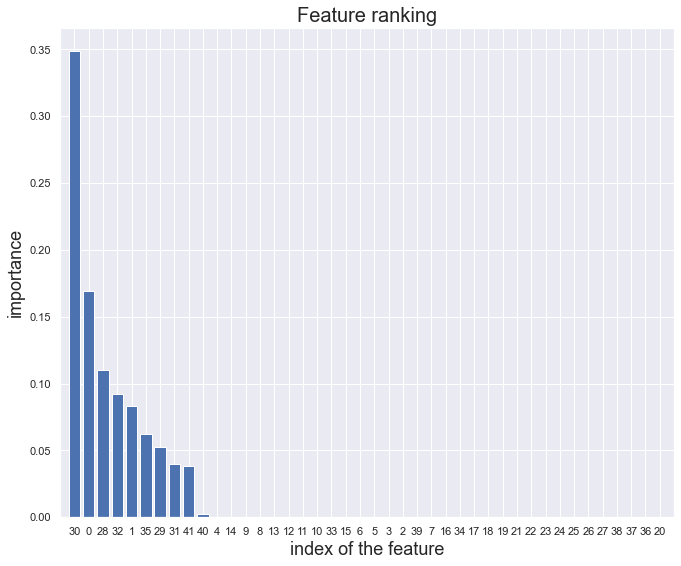

comp3_maint     0.348568
compressorID    0.169125
comp1_maint     0.110149
model2          0.092424
cycle           0.083574
age             0.062571
comp2_maint     0.052731
comp4_maint     0.039712
c-8760          0.038465
s-8760          0.002468
dtype: float64

complete---> rul_comp4



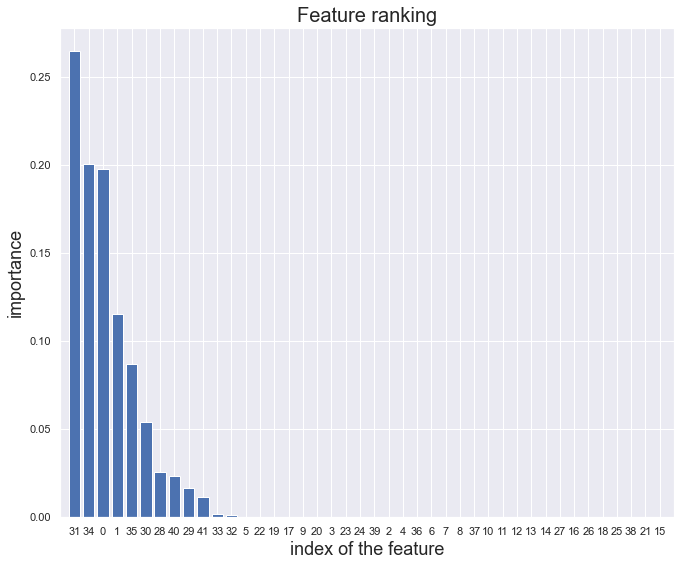

comp4_maint     0.264386
model4          0.200683
compressorID    0.197693
cycle           0.115541
age             0.086767
comp3_maint     0.053868
comp1_maint     0.025674
s-8760          0.023552
comp2_maint     0.016627
c-8760          0.011547
dtype: float64



In [56]:
for rul_comp in cols_rul:

  exec('y_temp = y_{}'.format(rul_comp))
  exec('X_temp = X_{}'.format(rul_comp))

  # First approach only with sensors
  single_rf.fit(X_temp, y_temp)
  y_pred = single_rf.predict(X_temp)

  print("complete---> " + rul_comp)
  print()

  # graph feature importance
  importances = single_rf.feature_importances_
  indices = np.argsort(importances)[::-1]
  feature_names = X_temp.columns    

  f, ax = plt.subplots(figsize=(11, 9))
  plt.title("Feature ranking", fontsize = 20)
  plt.bar(range(X_temp.shape[1]), importances[indices], color="b", align="center")
  plt.xticks(range(X_temp.shape[1]), indices) #feature_names, rotation='vertical')
  plt.xlim([-1, X_temp.shape[1]])
  plt.ylabel("importance", fontsize = 18)
  plt.xlabel("index of the feature", fontsize = 18)
  plt.show()

  # list feature importance
  important_features = pd.Series(data=single_rf.feature_importances_,index=X_temp.columns)
  important_features.sort_values(ascending=False,inplace=True)
  print(important_features.head(10))
  print()

# Apply Column Transformation

Some of the regression models need to normalize their variables before fitting the model

In [57]:
X.reset_index(inplace=True, drop= True)

In [58]:
y.reset_index(inplace=True, drop= True)

### Plot variables distributions

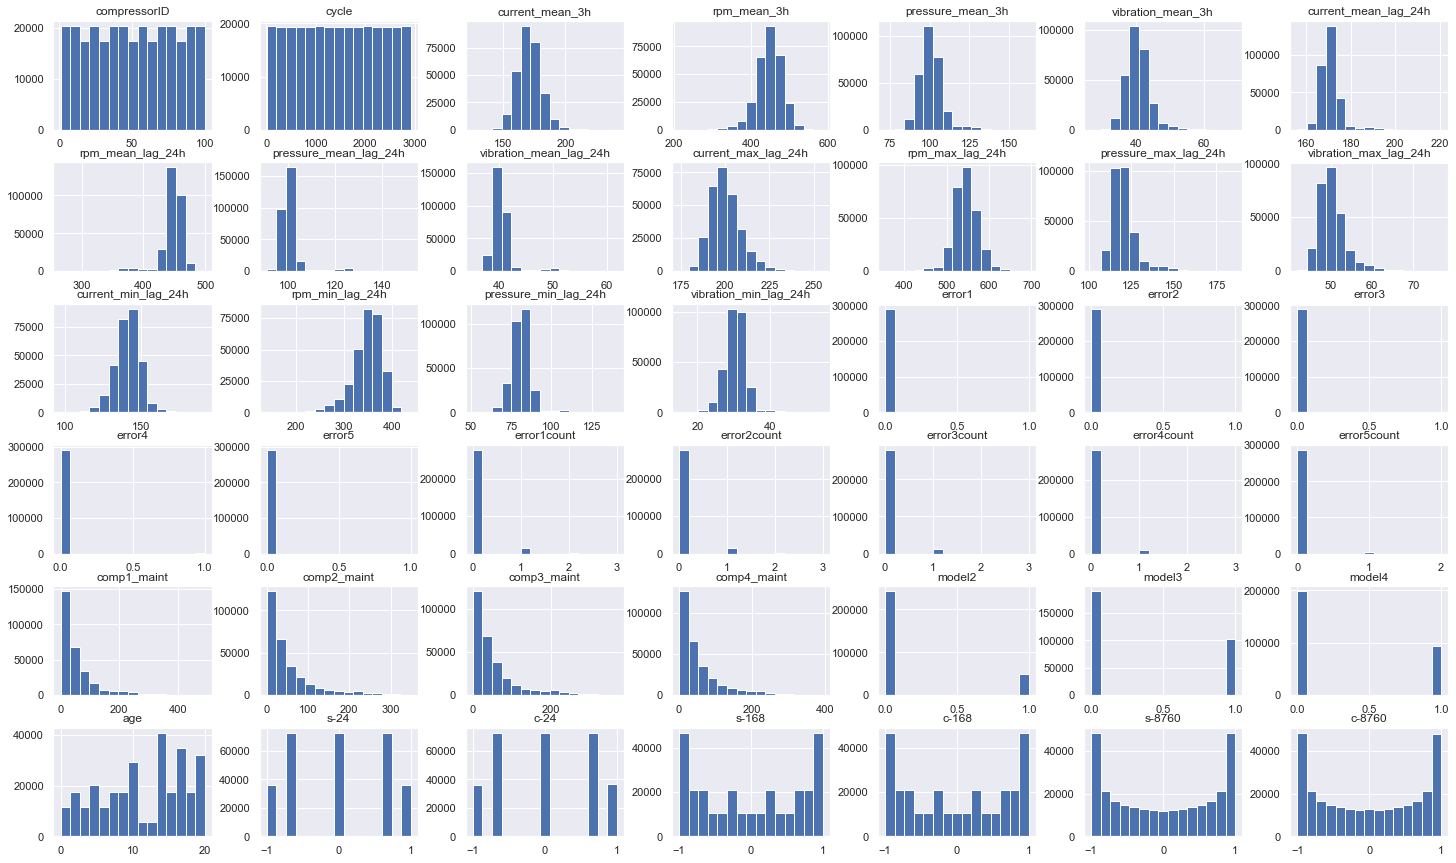

In [59]:
fig, axes = plt.subplots(len(X.columns)//7, 7, figsize=(25, 15))

i = 0
for triaxis in axes:
    for axis in triaxis:
        X.hist(column=X.columns[i], bins=15, ax=axis)

        i += 1

array([[<AxesSubplot:title={'center':'compressorID'}>,
        <AxesSubplot:title={'center':'cycle'}>,
        <AxesSubplot:title={'center':'current_mean_3h'}>,
        <AxesSubplot:title={'center':'rpm_mean_3h'}>,
        <AxesSubplot:title={'center':'pressure_mean_3h'}>,
        <AxesSubplot:title={'center':'vibration_mean_3h'}>],
       [<AxesSubplot:title={'center':'current_mean_lag_24h'}>,
        <AxesSubplot:title={'center':'rpm_mean_lag_24h'}>,
        <AxesSubplot:title={'center':'pressure_mean_lag_24h'}>,
        <AxesSubplot:title={'center':'vibration_mean_lag_24h'}>,
        <AxesSubplot:title={'center':'current_max_lag_24h'}>,
        <AxesSubplot:title={'center':'rpm_max_lag_24h'}>],
       [<AxesSubplot:title={'center':'pressure_max_lag_24h'}>,
        <AxesSubplot:title={'center':'vibration_max_lag_24h'}>,
        <AxesSubplot:title={'center':'current_min_lag_24h'}>,
        <AxesSubplot:title={'center':'rpm_min_lag_24h'}>,
        <AxesSubplot:title={'center':'pressure

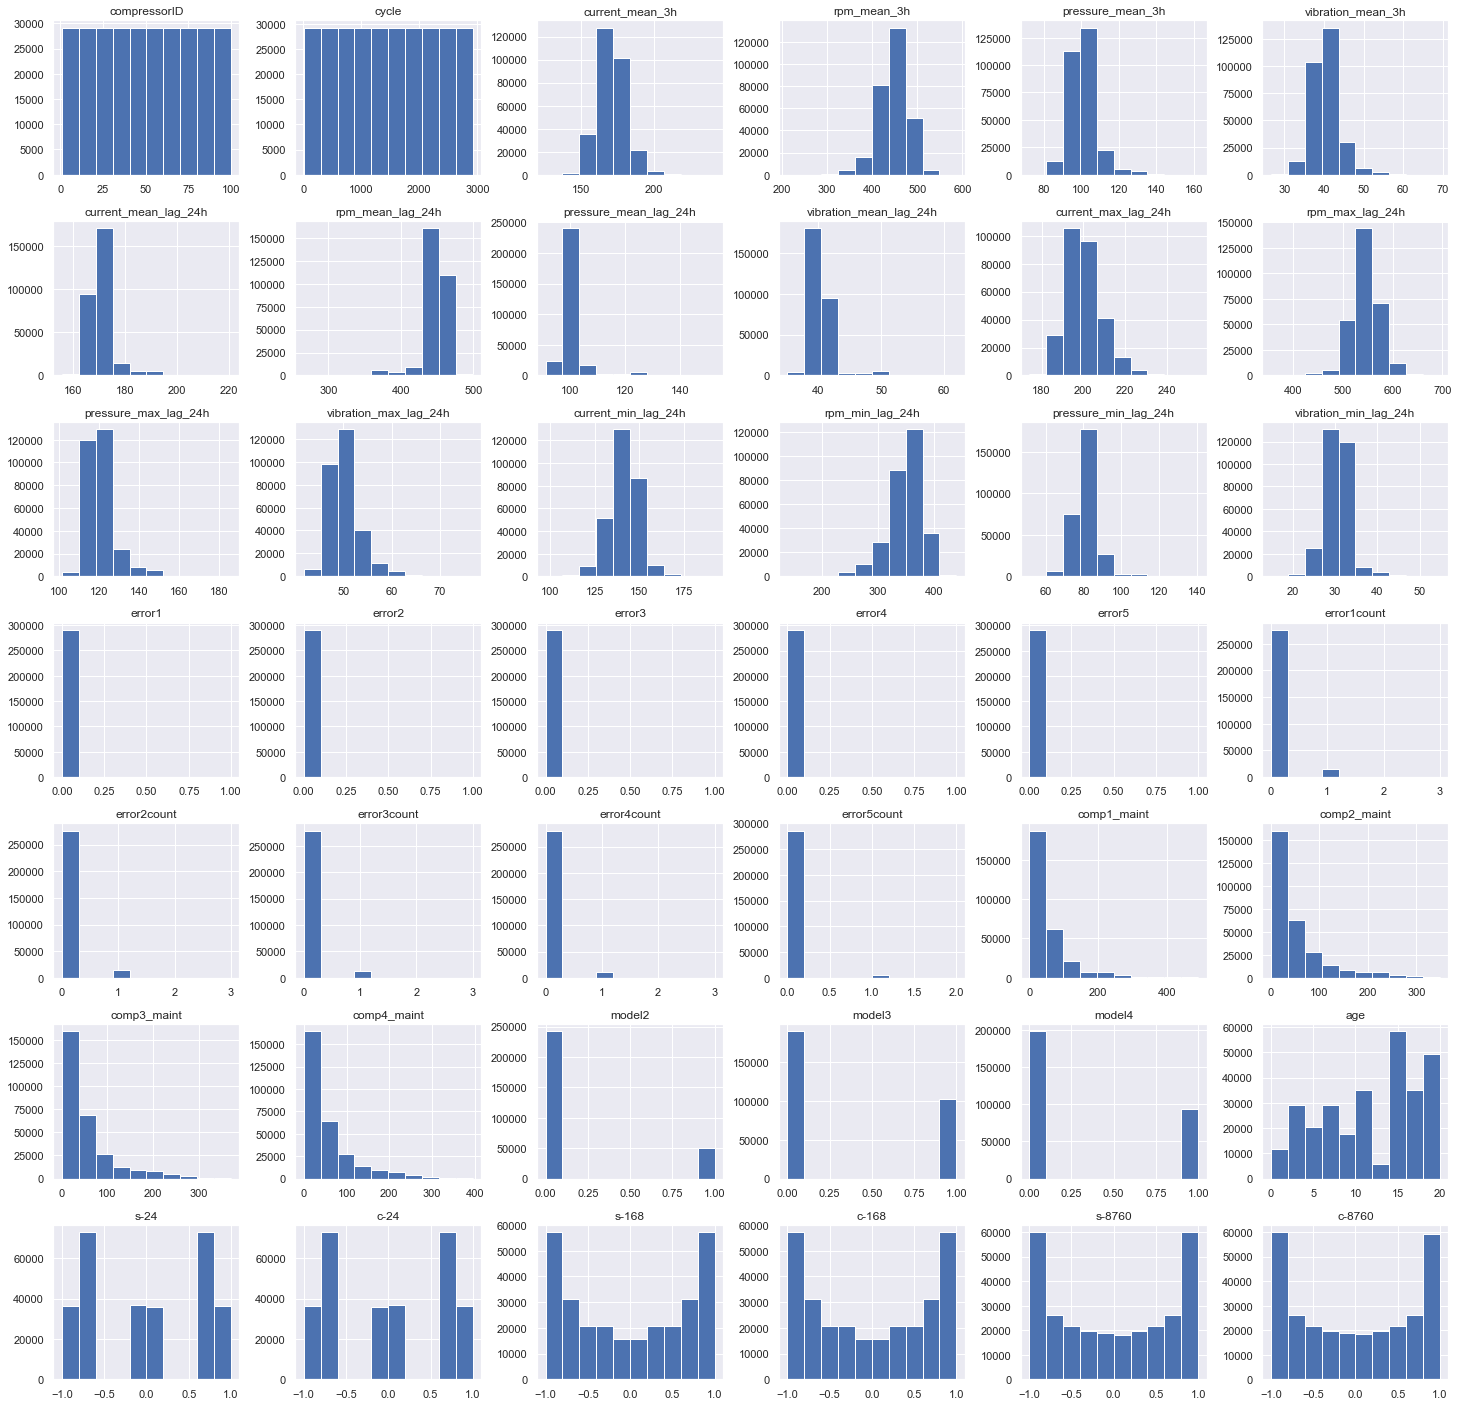

In [60]:
X.hist(figsize=(25,25))

## Apply Column Transformations

Dorp NaN for the X values

In [39]:
X.dropna(inplace=True)

In [40]:
y= y.loc[list(X.index)]

In [41]:
X.reset_index(drop=True,inplace=True)
y.reset_index(drop=True, inplace=True)

### Box-Cox

In [43]:
# setting preprocessing methods: PowerTransformer (Box-Cox, Yeo-Johnson); QuantileTransformer
scaler = MinMaxScaler(feature_range=(1, 2))
boxcox = PowerTransformer(method='box-cox')
bc = Pipeline(steps=[('s', scaler), ('bc', boxcox)])

In [44]:
X_bc = bc.fit_transform(X)

X_bc = pd.DataFrame(X_bc, columns=X.columns)

X_bc

,compressorID,cycle,current_mean_3h,rpm_mean_3h,pressure_mean_3h,vibration_mean_3h,current_mean_lag_24h,rpm_mean_lag_24h,pressure_mean_lag_24h,vibration_mean_lag_24h,...,model2,model3,model4,age,s-24,c-24,s-168,c-168,s-8760,c-8760
0,-1.767249,-1.784994,0.993996,-0.256291,-0.967310,0.434725,-0.081354,-0.339499,-1.583841,0.282619,...,-0.45257,1.362770,-0.685994,1.173864,-0.996063,0.996117,0.996333,0.996473,0.069424,1.371370
1,-1.767249,-1.783683,0.623827,-0.294110,0.227307,-1.350162,0.152273,-0.254348,-1.550618,-0.218076,...,-0.45257,1.362770,-0.685994,1.173864,0.048586,1.367887,1.092281,0.888183,0.072430,1.371327
2,-1.767249,-1.782372,-1.112901,-0.727862,-0.057397,-1.354368,-0.037573,-0.206921,-1.041957,-0.427759,...,-0.45257,1.362770,-0.685994,1.173864,0.997516,0.996117,1.174995,0.768597,0.075436,1.371277
3,-1.767249,-1.781062,0.016703,-0.185856,0.342076,0.127810,0.308620,-0.405638,-1.667706,0.170855,...,-0.45257,1.362770,-0.685994,1.173864,1.368820,0.046758,1.243713,0.638887,0.078440,1.371223
4,-1.767249,-1.779751,-0.778022,0.652042,0.389110,0.256101,0.197296,-0.098753,-2.292467,0.039735,...,-0.45257,1.362770,-0.685994,1.173864,0.997516,-0.996955,1.297809,0.500358,0.081444,1.371162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291395,1.669725,1.681186,-0.460472,-0.726576,-0.250776,-3.721455,0.381370,0.218047,0.624460,-0.727831,...,-0.45257,-0.733799,1.457738,-1.091083,0.048586,-1.466220,0.638777,1.243875,0.036290,1.371465
291396,1.669725,1.682288,-1.358636,1.938945,1.047411,0.016106,-0.346974,0.885606,0.348484,-1.945719,...,-0.45257,-0.733799,1.457738,-1.091083,-0.996063,-0.996955,0.768476,1.175151,0.039307,1.371485
291397,1.669725,1.683389,-0.000881,-0.314933,0.337375,1.847004,-0.286371,1.596371,0.557507,-0.466330,...,-0.45257,-0.733799,1.457738,-1.091083,-1.466293,0.046758,0.888053,1.092429,0.042322,1.371500
291398,1.669725,1.684491,1.221927,-0.395742,-0.179817,0.759732,0.670441,1.051476,0.504225,-0.031592,...,-0.45257,-0.733799,1.457738,-1.091083,-0.996063,0.996117,0.996333,0.996473,0.045337,1.371508


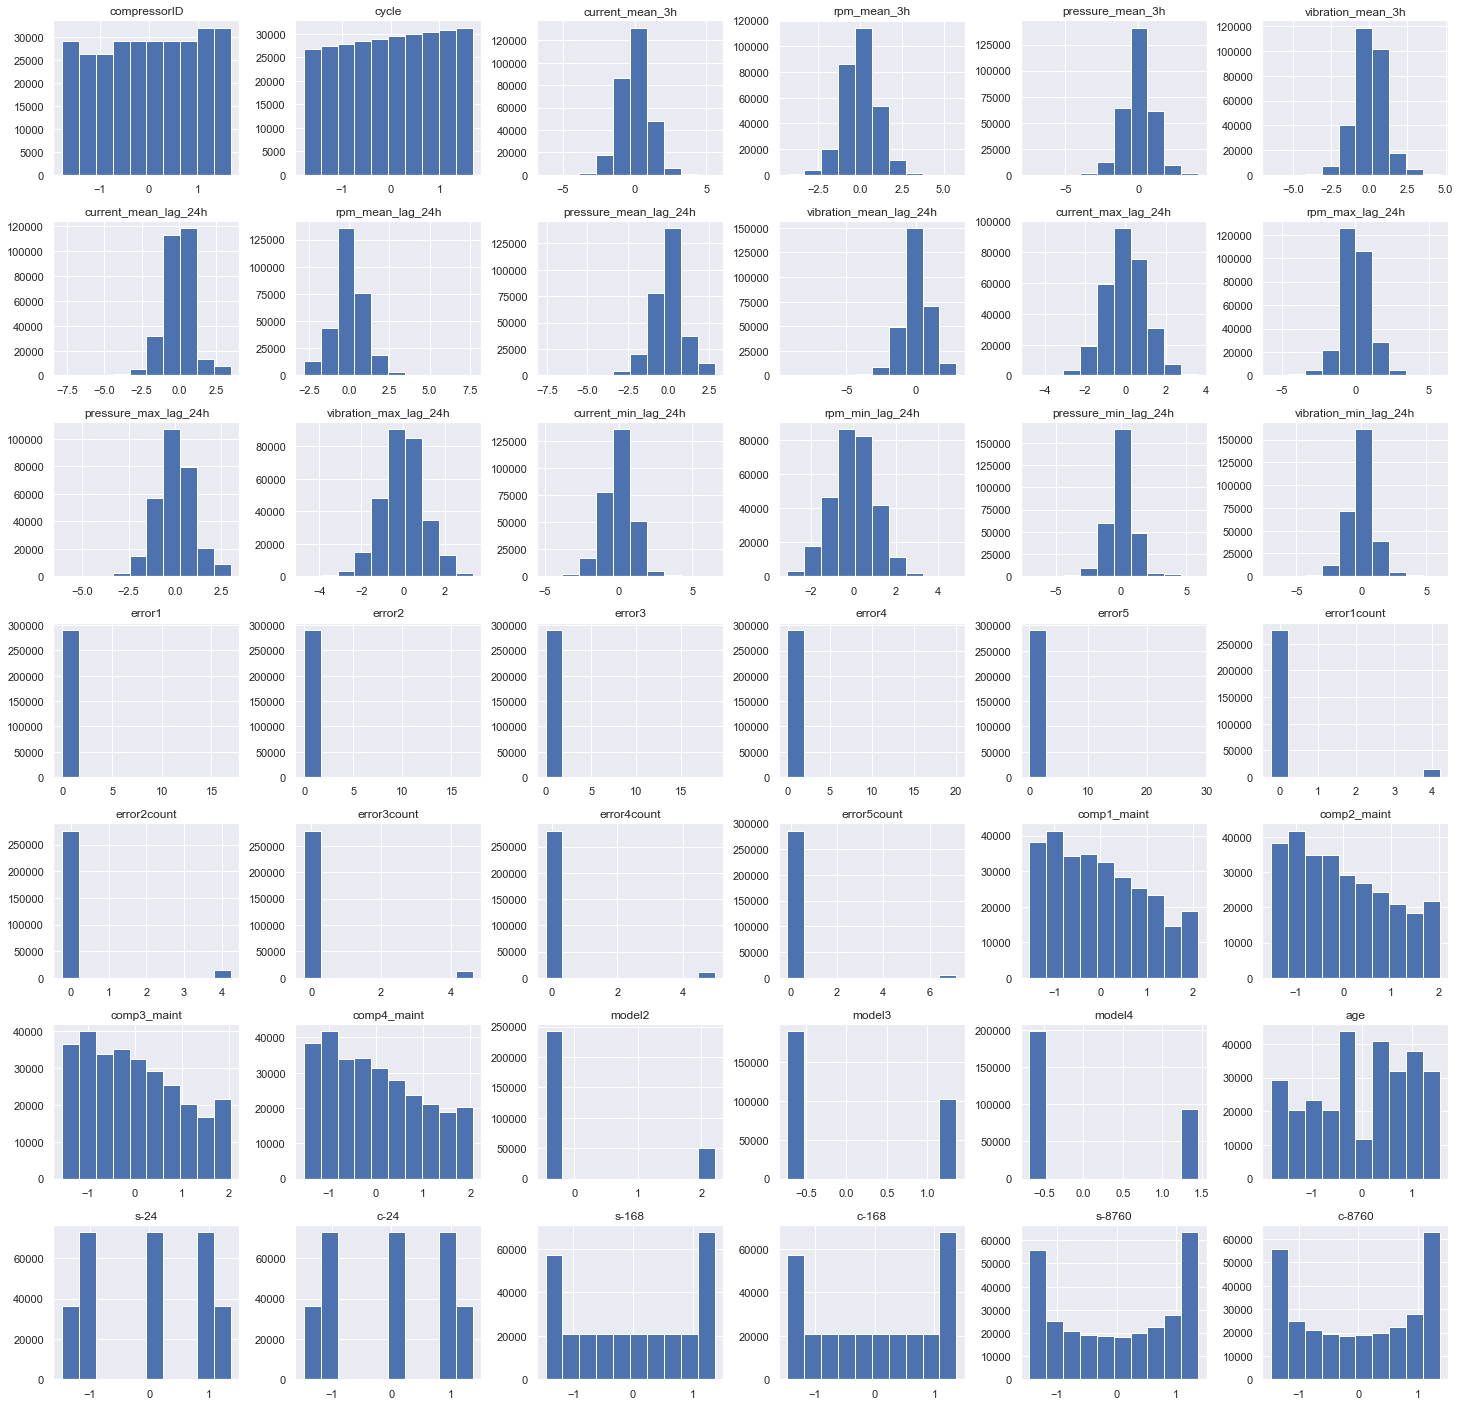

In [45]:
# Final distribution of the features
X_bc.hist(figsize=(25,25));

### Yeo-Johnson

In [62]:
yj = PowerTransformer(method='yeo-johnson')

In [63]:
X_yj = yj.fit_transform(X)

X_yj = pd.DataFrame(X_yj, columns=X.columns)

X_yj

,compressorID,cycle,current_mean_3h,rpm_mean_3h,pressure_mean_3h,vibration_mean_3h,current_mean_lag_24h,rpm_mean_lag_24h,pressure_mean_lag_24h,vibration_mean_lag_24h,...,model2,model3,model4,age,s-24,c-24,s-168,c-168,s-8760,c-8760
0,-2.026580,-2.139543,0.994142,-0.256619,-0.966151,0.433226,-0.148251,-0.339595,-1.281015,0.139532,...,-0.45257,1.362770,-0.685994,1.136020,-0.999837,0.999014,0.999255,0.999409,0.021334,1.417488
1,-2.026580,-2.134816,0.623977,-0.294506,0.226828,-1.347975,0.049417,-0.254522,-1.281015,-0.348829,...,-0.45257,1.362770,-0.685994,1.136020,0.000617,1.413556,1.105041,0.881034,0.024373,1.417439
2,-2.026580,-2.130222,-1.113057,-0.728999,-0.057396,-1.352181,-0.123542,-0.207136,-0.960761,-0.558127,...,-0.45257,1.362770,-0.685994,1.136020,1.000506,0.999014,1.196914,0.751573,0.027413,1.417383
3,-2.026580,-2.125747,0.016767,-0.186057,0.341409,0.127069,0.197668,-0.405670,-1.387766,0.000000,...,-0.45257,1.362770,-0.685994,1.136020,1.414543,-0.001269,1.273717,0.612657,0.030452,1.417321
4,-2.026580,-2.121377,-0.778128,0.653000,0.388369,0.255025,0.098834,-0.099051,-1.814771,-0.069766,...,-0.45257,1.362770,-0.685994,1.136020,1.000506,-1.000643,1.334480,0.466039,0.033491,1.417253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291395,1.559439,1.556162,-0.460511,-0.727711,-0.250459,-3.737012,0.271793,0.217578,0.533756,-0.767424,...,-0.45257,-0.733799,1.457738,-1.081237,0.000617,-1.414387,0.612542,1.273899,-0.012105,1.417596
291396,1.559439,1.557082,-1.358812,1.938638,1.045953,0.015671,-0.420044,0.885160,0.213502,-1.953443,...,-0.45257,-0.733799,1.457738,-1.081237,-0.999837,-1.000643,0.751444,1.197088,-0.009065,1.417619
291397,1.559439,1.558001,-0.000821,-0.315368,0.336716,1.847279,-0.370627,1.596564,0.427005,-0.558127,...,-0.45257,-0.733799,1.457738,-1.081237,-1.414370,-0.001269,0.880892,1.105205,-0.006025,1.417635
291398,1.559439,1.558920,1.222040,-0.396322,-0.179613,0.757675,0.568294,1.051122,0.427005,-0.139532,...,-0.45257,-0.733799,1.457738,-1.081237,-0.999837,0.999014,0.999255,0.999409,-0.002985,1.417645


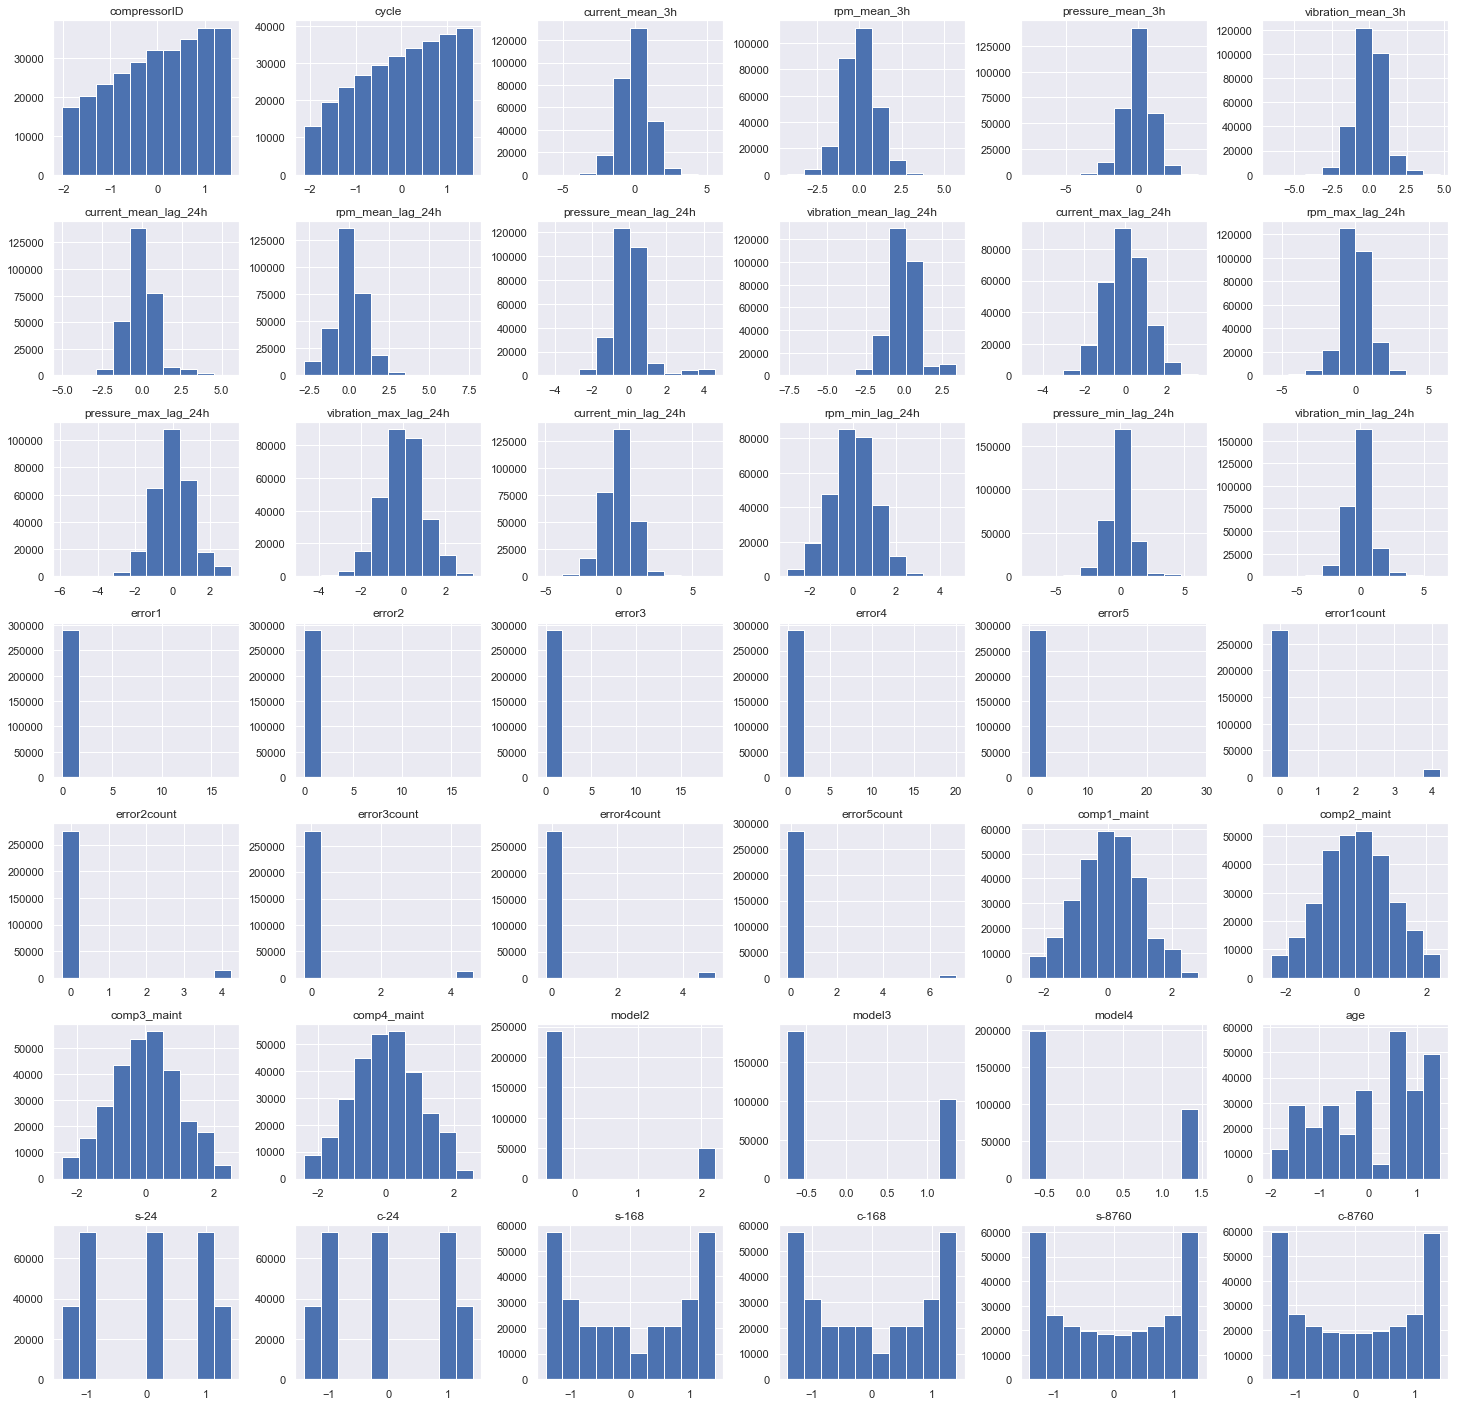

In [64]:
# Final distribution of the features
X_yj.hist(figsize=(25,25));

### Quartile Transformation

In [49]:
rng = np.random.RandomState(102)
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',
                          random_state=rng)

In [50]:
X_trf = qt.fit_transform(X)

X_trf = pd.DataFrame(X_trf, columns=X.columns)

X_trf

,compressorID,cycle,current_mean_3h,rpm_mean_3h,pressure_mean_3h,vibration_mean_3h,current_mean_lag_24h,rpm_mean_lag_24h,pressure_mean_lag_24h,vibration_mean_lag_24h,...,model2,model3,model4,age,s-24,c-24,s-168,c-168,s-8760,c-8760
0,-5.199338,-5.199338,1.043636,-0.255803,-1.029223,0.458267,-0.153803,-0.363216,-1.586184,0.286666,...,-5.199338,5.199338,-5.199338,1.079060,-0.688748,0.676067,0.667674,0.666628,0.021351,2.796502
1,-5.199338,-3.402386,0.651348,-0.296926,0.213960,-1.367044,0.119279,-0.258893,-1.560254,-0.307688,...,-5.199338,5.199338,-5.199338,1.079060,0.004974,5.199338,0.789775,0.557546,0.022607,2.721334
2,-5.199338,-3.208131,-1.140314,-0.771615,-0.108866,-1.370830,-0.103490,-0.199702,-1.132555,-0.535928,...,-5.199338,5.199338,-5.199338,1.079060,0.677646,0.685567,0.913991,0.452510,0.024282,2.651394
3,-5.199338,-3.089638,0.007011,-0.182785,0.353674,0.109684,0.311942,-0.448448,-1.651183,0.146752,...,-5.199338,5.199338,-5.199338,1.079060,5.199338,0.000282,1.064193,0.359940,0.025957,2.603608
4,-5.199338,-3.003150,-0.811567,0.683114,0.407558,0.254545,0.174748,-0.072605,-2.087170,-0.012786,...,-5.199338,5.199338,-5.199338,1.079060,0.691935,-0.644829,1.241479,0.261655,0.027632,2.556904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291395,5.199338,2.947224,-0.489933,-0.770309,-0.321889,-2.958511,0.402312,0.294964,0.752024,-0.842146,...,-5.199338,-5.199338,5.199338,-0.872812,0.318024,-5.199338,0.319300,1.144286,0.007535,3.124454
291396,5.199338,3.035069,-1.376117,1.890971,1.205668,-0.015182,-0.447218,0.968948,0.374879,-1.850850,...,-5.199338,-5.199338,5.199338,-0.872812,-0.344566,-1.106438,0.436754,0.952820,0.009209,3.289961
291397,5.199338,3.155323,-0.010298,-0.320784,0.347856,1.823401,-0.383322,1.586640,0.659230,-0.575446,...,-5.199338,-5.199338,5.199338,-0.872812,-5.199338,-0.225406,0.530366,0.825976,0.010884,3.511646
291398,5.199338,3.352241,1.274510,-0.409148,-0.244799,0.838468,0.771653,1.124927,0.585627,-0.094662,...,-5.199338,-5.199338,5.199338,-0.872812,-0.628570,0.737330,0.629444,0.711210,0.012559,3.864460


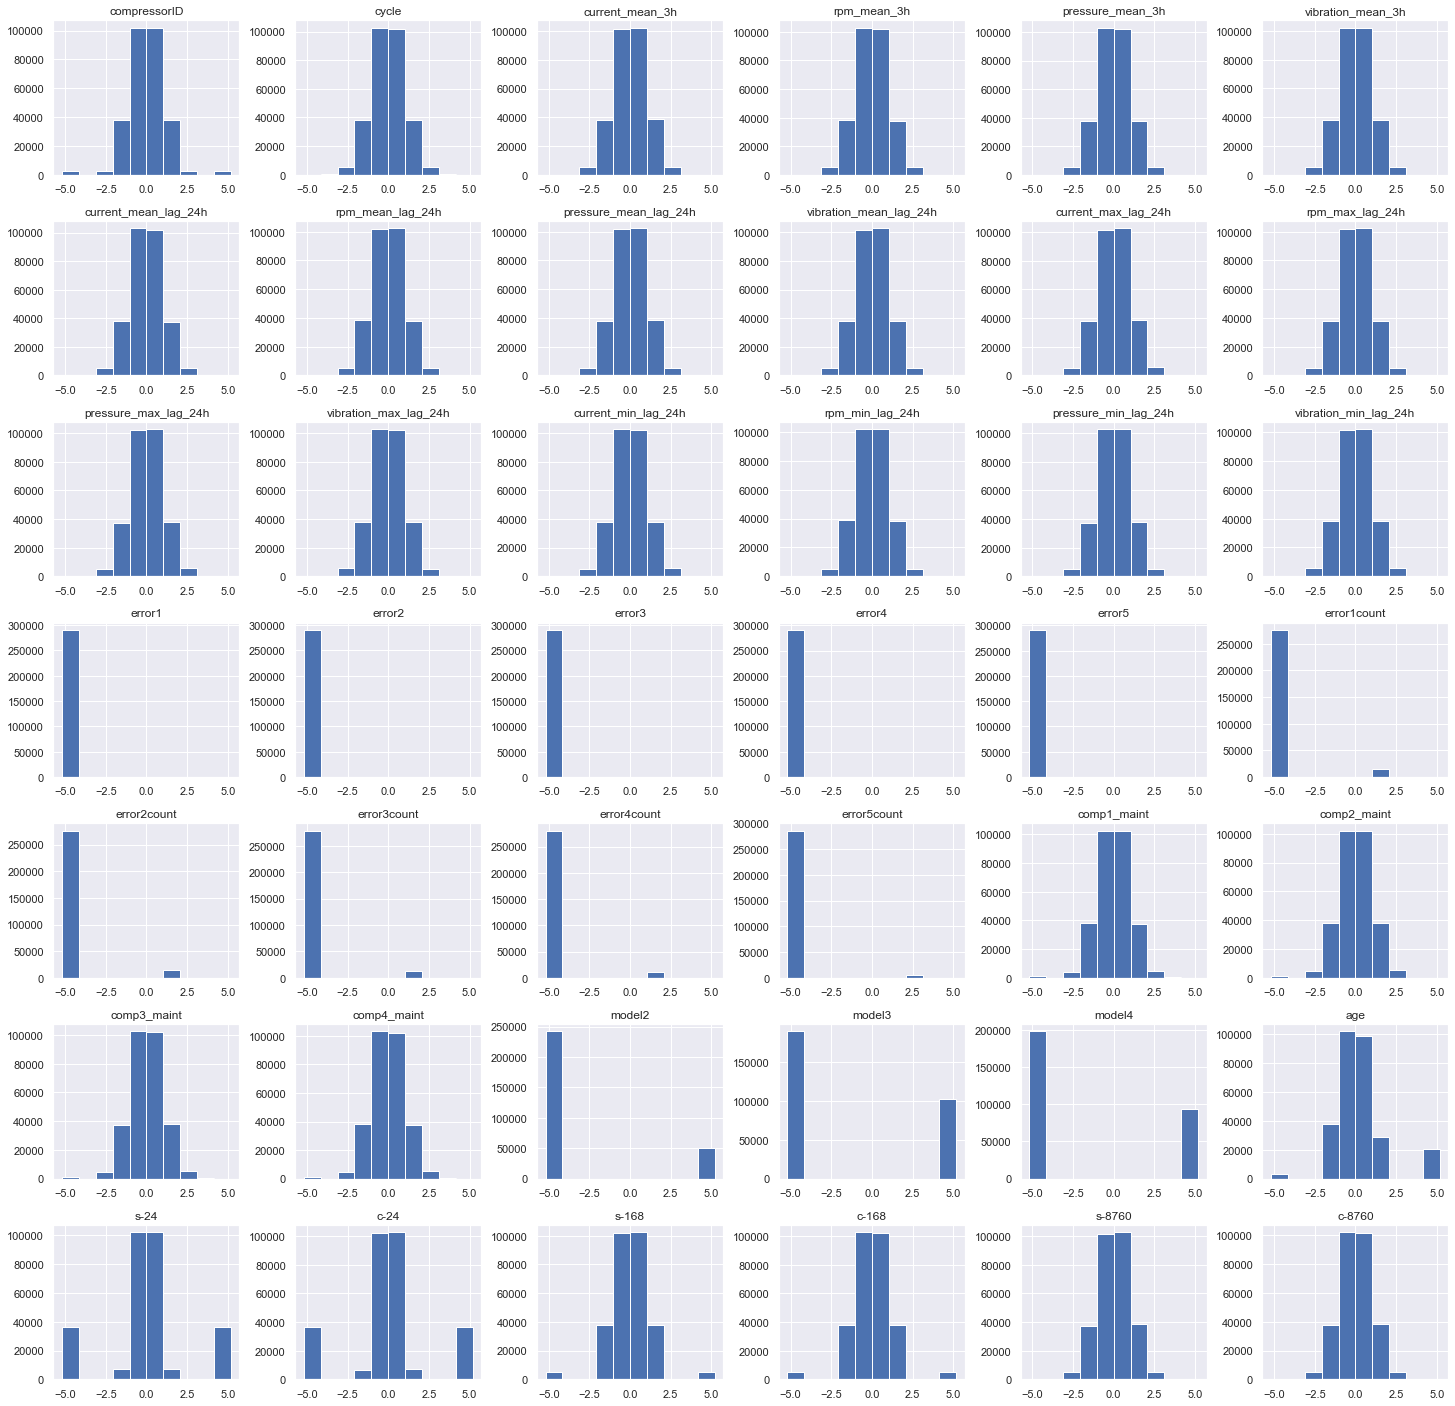

In [51]:
# Final distribution of the features
X_trf.hist(figsize=(25,25));

## Compare performances

Let's see which of the power transformations perform better in the tree models

In [52]:
# Listing models
models = []
models.append(('RF', RandomForestRegressor()))
models.append(('CB', CatBoostRegressor(verbose=False)))
models.append(('XGB', xgb.XGBRegressor(objective ='reg:linear', verbosity = 0)))


In [53]:
num_splits = 2

Many machine learning algorithms perform better when the distribution of variables is Gaussian. To this aim, PowerTransformations will be applied since they will make the probability distribution of a variable more Gaussian.

In [54]:
#Without PowerTransformations
df_models, results = run_cv_reg(models, X, y, num_splits,evaluator='r2')
df_models

Executing RF...
CV finished for RF and rul_comp1
CV finished for RF and rul_comp2
CV finished for RF and rul_comp3
CV finished for RF and rul_comp4
Executing CB...
CV finished for CB and rul_comp1
CV finished for CB and rul_comp2
CV finished for CB and rul_comp3
CV finished for CB and rul_comp4
Executing XGB...
CV finished for XGB and rul_comp1
CV finished for XGB and rul_comp2
CV finished for XGB and rul_comp3
CV finished for XGB and rul_comp4


,model,component,min_r2_score,1st_quantile,median_r2_score,mean_r2_score,std_r2_score,3rd_quantile,max_r2_score,exec_time_sec,time_score_ratio
0,RF,rul_comp1,0.9968,0.9969,0.9969,0.9969,0.0001,0.9969,0.9969,309.1815,0.0032
1,RF,rul_comp2,0.9972,0.9973,0.9973,0.9973,0.0001,0.9974,0.9975,738.7795,0.0013
2,RF,rul_comp3,0.9934,0.9935,0.9936,0.9936,0.0002,0.9936,0.9937,884.8777,0.0011
3,RF,rul_comp4,0.9945,0.9947,0.9949,0.9949,0.0003,0.9950,0.9952,1105.1622,0.0009
4,CB,rul_comp1,0.9917,0.9917,0.9918,0.9918,0.0001,0.9918,0.9919,14.7755,0.0671
5,CB,rul_comp2,0.9824,0.9824,0.9825,0.9825,0.0001,0.9825,0.9826,31.7369,0.0310
6,CB,rul_comp3,0.9939,0.9939,0.9939,0.9939,0.0001,0.9940,0.9940,42.2512,0.0235
7,CB,rul_comp4,0.9923,0.9923,0.9923,0.9923,0.0001,0.9924,0.9924,55.7115,0.0178
8,XGB,rul_comp1,0.9884,0.9885,0.9886,0.9886,0.0001,0.9886,0.9887,20.8813,0.0473
9,XGB,rul_comp2,0.9784,0.9786,0.9787,0.9787,0.0003,0.9788,0.9789,49.9630,0.0196


In [55]:
#Box-Cox
df_bc, results_bc =run_cv_reg(models, X_bc, y, num_splits,evaluator='r2')
df_bc

Executing RF...
CV finished for RF and rul_comp1
CV finished for RF and rul_comp2
CV finished for RF and rul_comp3
CV finished for RF and rul_comp4
Executing CB...
CV finished for CB and rul_comp1
CV finished for CB and rul_comp2
CV finished for CB and rul_comp3
CV finished for CB and rul_comp4
Executing XGB...
CV finished for XGB and rul_comp1
CV finished for XGB and rul_comp2
CV finished for XGB and rul_comp3
CV finished for XGB and rul_comp4


,model,component,min_r2_score,1st_quantile,median_r2_score,mean_r2_score,std_r2_score,3rd_quantile,max_r2_score,exec_time_sec,time_score_ratio
0,RF,rul_comp1,0.9969,0.9970,0.9971,0.9971,0.0001,0.9972,0.9972,346.5088,0.0029
1,RF,rul_comp2,0.9972,0.9973,0.9973,0.9973,0.0002,0.9974,0.9975,792.1324,0.0013
2,RF,rul_comp3,0.9937,0.9938,0.9940,0.9940,0.0003,0.9942,0.9943,927.0997,0.0011
3,RF,rul_comp4,0.9946,0.9948,0.9950,0.9950,0.0004,0.9952,0.9953,1141.3839,0.0009
4,CB,rul_comp1,0.9916,0.9918,0.9920,0.9920,0.0003,0.9921,0.9923,15.3327,0.0647
5,CB,rul_comp2,0.9824,0.9826,0.9829,0.9829,0.0005,0.9831,0.9833,31.5699,0.0311
6,CB,rul_comp3,0.9940,0.9940,0.9940,0.9940,0.0000,0.9940,0.9940,41.6832,0.0238
7,CB,rul_comp4,0.9920,0.9921,0.9922,0.9922,0.0002,0.9923,0.9923,55.0704,0.0180
8,XGB,rul_comp1,0.9881,0.9881,0.9881,0.9881,0.0001,0.9882,0.9882,21.2504,0.0465
9,XGB,rul_comp2,0.9799,0.9800,0.9801,0.9801,0.0002,0.9802,0.9803,56.0859,0.0175


In [56]:
#Yeo-Johnson
df_yj, results_yj =run_cv_reg(models, X_yj, y, num_splits,evaluator='r2')
df_yj

Executing RF...
CV finished for RF and rul_comp1
CV finished for RF and rul_comp2
CV finished for RF and rul_comp3
CV finished for RF and rul_comp4
Executing CB...
CV finished for CB and rul_comp1
CV finished for CB and rul_comp2
CV finished for CB and rul_comp3
CV finished for CB and rul_comp4
Executing XGB...
CV finished for XGB and rul_comp1
CV finished for XGB and rul_comp2
CV finished for XGB and rul_comp3
CV finished for XGB and rul_comp4


,model,component,min_r2_score,1st_quantile,median_r2_score,mean_r2_score,std_r2_score,3rd_quantile,max_r2_score,exec_time_sec,time_score_ratio
0,RF,rul_comp1,0.9969,0.9970,0.9971,0.9971,0.0002,0.9971,0.9972,406.3883,0.0025
1,RF,rul_comp2,0.9972,0.9973,0.9974,0.9974,0.0002,0.9974,0.9975,757.0901,0.0013
2,RF,rul_comp3,0.9934,0.9936,0.9938,0.9938,0.0004,0.9940,0.9942,876.7957,0.0011
3,RF,rul_comp4,0.9947,0.9948,0.9950,0.9950,0.0003,0.9951,0.9953,1061.8932,0.0009
4,CB,rul_comp1,0.9917,0.9919,0.9920,0.9920,0.0003,0.9921,0.9923,13.2398,0.0749
5,CB,rul_comp2,0.9827,0.9828,0.9829,0.9829,0.0001,0.9829,0.9830,29.3515,0.0335
6,CB,rul_comp3,0.9938,0.9938,0.9939,0.9939,0.0001,0.9939,0.9940,38.9186,0.0255
7,CB,rul_comp4,0.9920,0.9920,0.9920,0.9920,0.0001,0.9921,0.9921,50.8980,0.0195
8,XGB,rul_comp1,0.9876,0.9878,0.9880,0.9880,0.0003,0.9881,0.9883,17.4227,0.0567
9,XGB,rul_comp2,0.9792,0.9796,0.9800,0.9800,0.0008,0.9804,0.9808,38.5781,0.0254


In [57]:
#Quartile Transformation
df_qt, results_qt = run_cv_reg(models, X_trf, y, num_splits,evaluator='r2')
df_qt

Executing RF...
CV finished for RF and rul_comp1
CV finished for RF and rul_comp2
CV finished for RF and rul_comp3
CV finished for RF and rul_comp4
Executing CB...
CV finished for CB and rul_comp1
CV finished for CB and rul_comp2
CV finished for CB and rul_comp3
CV finished for CB and rul_comp4
Executing XGB...
CV finished for XGB and rul_comp1
CV finished for XGB and rul_comp2
CV finished for XGB and rul_comp3
CV finished for XGB and rul_comp4


,model,component,min_r2_score,1st_quantile,median_r2_score,mean_r2_score,std_r2_score,3rd_quantile,max_r2_score,exec_time_sec,time_score_ratio
0,RF,rul_comp1,0.9969,0.9969,0.9970,0.9970,0.0001,0.9970,0.9971,281.6766,0.0035
1,RF,rul_comp2,0.9971,0.9973,0.9974,0.9974,0.0003,0.9975,0.9977,672.2768,0.0015
2,RF,rul_comp3,0.9935,0.9936,0.9938,0.9938,0.0003,0.9939,0.9940,803.6316,0.0012
3,RF,rul_comp4,0.9943,0.9946,0.9949,0.9949,0.0006,0.9952,0.9955,1012.3953,0.0010
4,CB,rul_comp1,0.9917,0.9917,0.9917,0.9917,0.0000,0.9917,0.9917,14.4990,0.0684
5,CB,rul_comp2,0.9824,0.9825,0.9826,0.9826,0.0002,0.9826,0.9827,31.1480,0.0315
6,CB,rul_comp3,0.9938,0.9938,0.9939,0.9939,0.0001,0.9939,0.9940,41.4854,0.0240
7,CB,rul_comp4,0.9920,0.9921,0.9922,0.9922,0.0002,0.9924,0.9925,54.0336,0.0184
8,XGB,rul_comp1,0.9881,0.9883,0.9885,0.9885,0.0004,0.9887,0.9890,18.9495,0.0522
9,XGB,rul_comp2,0.9796,0.9798,0.9799,0.9799,0.0003,0.9800,0.9802,43.0991,0.0227


# Comparing ML algorithms

### Possible models

In the following schema we will find different type of Machine Learning applied to Predictive Maintenance

![](https://drive.google.com/uc?export=view&id=13Nid2gr5iT2Qiqw-0MluE-vwtCNmxyH4) 


### Compare the different Regression Algorithms

We will use the Yeo-Jhonson transform as input for the models since was the transformation with best performance. 

In [65]:
X= X_yj

In [71]:
for rul_comp in y.columns:
  exec('y_{} = pd.DataFrame()'.format(rul_comp))
  exec('y_{} = y[rul_comp]'.format(rul_comp))
  exec('y_{}.dropna(inplace=True)'.format(rul_comp))
  exec('temp= X.loc[list(y_{}.index)]'.format(rul_comp))
  exec('X_{}= temp'.format(rul_comp))
  exec('y_list.append(str("y_{}"))'.format(rul_comp))
  exec('X_list.append(str("X_{}"))'.format(rul_comp))

We will use k-fold popular cross-validation technique. It iterates through different sets and hence provides visibility of the whole data. In num_splits= 4 for example, 3 folds for training and 1 fold for testing purpose and this repeats unless all folds get a chance to be the test set one by one.

In [75]:
# Defining the algorithm function

# Compare Algorithms

# prepare configuration for cross validation test harness
seed = 7
# number of splits
num_splits = 3
#Scoring
scoring = 'r2'

# prepare models
models = []
models.append(('LR', LinearRegression()))
models.append(('GLM', ElasticNet()))
models.append(('LASSO', Lasso()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('DTR', DecisionTreeRegressor()))
models.append(('RD', Ridge(alpha=100)))
models.append(('RF', ensemble.RandomForestRegressor()))
models.append(('XGB', xgb.XGBRegressor()))
models.append(('GB', GradientBoostingRegressor()))
models.append(('CB', CatBoostRegressor(verbose=False)))
#models.append(('SVR', SVR())) very time consuming and poor performance

# Evaluate each model
names = []
results = []
mins = []
quartiles_1 = []
medians = []
means = []
stds = []
quartiles_3 = []
maxs = []
times = []


def run_cv_algorithm(name, model, features, target):
  '''
  Function that runs the cross-validation (CV) for the named algorithm
  - name: Designation of the algorithm. 
  - model: Algorithm to be applied.
  '''
  kfold = model_selection.KFold(n_splits=num_splits, random_state=seed, shuffle=True)
  cv_results = model_selection.cross_val_score(estimator=model,
                                              X=features,
                                              y=target,
                                              cv=kfold,
                                              scoring=scoring)
  # appending stats to lists
  names.append(name)
  results.append(cv_results)
  mins.append(cv_results.min())
  quartiles_1.append(np.percentile(cv_results, 25)) # Q1
  medians.append(np.median(cv_results)) # Q2 = median
  means.append(cv_results.mean())
  stds.append(cv_results.std())
  quartiles_3.append(np.percentile(cv_results, 75)) # Q3
  maxs.append(cv_results.max())
  
  msg = "{}: {} ({})".format(name, cv_results.mean(), cv_results.std())
  print(msg)

Evaluating for component:  rul_comp1

LR: 0.1736381154675564 (0.0010031216729302207)
LR execution time (sec): 0.8500568866729736
GLM: 0.14189396697593673 (0.0009276323208937908)
GLM execution time (sec): 0.35608601570129395
LASSO: 0.16862714972101642 (0.0010919060160785002)
LASSO execution time (sec): 0.3646070957183838
KNN: 0.746404928406673 (0.005827296272383523)
KNN execution time (sec): 277.38470792770386
DTR: 0.993969725428346 (0.001428136165047271)
DTR execution time (sec): 7.953594207763672
RD: 0.17363789302406832 (0.001004131610512188)
RD execution time (sec): 0.2522091865539551
RF: 0.997106938478843 (0.0004975533040071587)
RF execution time (sec): 493.9914629459381
XGB: 0.9893074611919123 (0.0006567422586419544)
XGB execution time (sec): 30.617278814315796
GB: 0.6095065830276628 (0.0017446560792831985)
GB execution time (sec): 159.95888829231262
CB: 0.9928029490554376 (0.00023545415980641147)
CB execution time (sec): 23.408225774765015


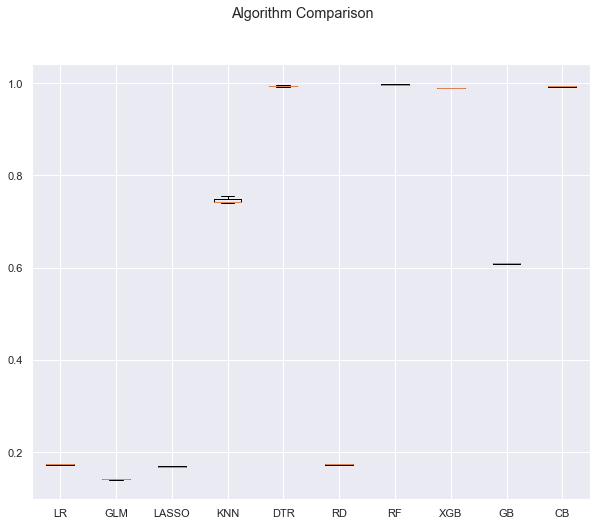


Evaluating for component:  rul_comp2

LR: 0.15828763453827646 (0.00036375981145626325)
LR execution time (sec): 1.1285479068756104
GLM: 0.13532925371171356 (0.0006604899996566713)
GLM execution time (sec): 0.4426841735839844
LASSO: 0.15483880727058905 (0.0006122388020504804)
LASSO execution time (sec): 0.4820559024810791
KNN: 0.7375909024212776 (0.0010916840146609722)
KNN execution time (sec): 459.48872900009155
DTR: 0.9951050626342228 (0.00047504657730074407)
DTR execution time (sec): 11.245520114898682
RD: 0.1582873864207245 (0.00036391257999433867)
RD execution time (sec): 0.3423349857330322
RF: 0.997636933247111 (0.00015893588650573007)
RF execution time (sec): 696.4485790729523
XGB: 0.979120512191671 (0.0017322732063656497)
XGB execution time (sec): 38.36684012413025
GB: 0.5611870377136756 (0.0023812757621176424)
GB execution time (sec): 208.6632478237152
CB: 0.984867404301625 (0.0002724939696366968)
CB execution time (sec): 26.519882917404175


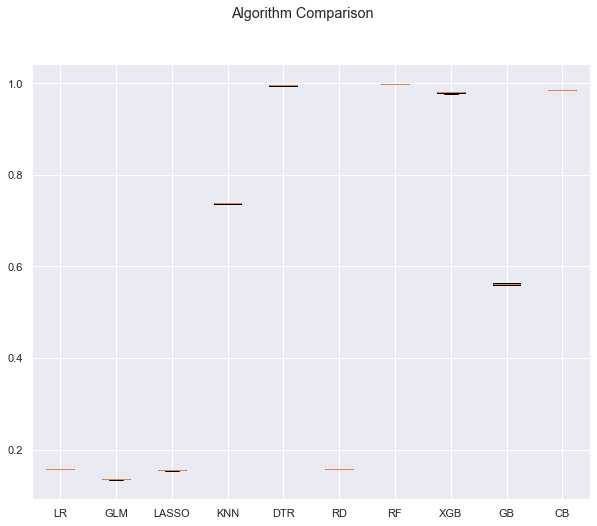


Evaluating for component:  rul_comp3

LR: 0.3013112887117288 (0.0003950150032072055)
LR execution time (sec): 0.36157798767089844
GLM: 0.2513134061034884 (0.000557854093440522)
GLM execution time (sec): 0.19026780128479004
LASSO: 0.2929344629578264 (0.0005141846408316658)
LASSO execution time (sec): 0.19935107231140137
KNN: 0.7613778006396025 (0.00236137328907191)
KNN execution time (sec): 75.68837594985962
DTR: 0.9894271944525338 (0.0020482372282004196)
DTR execution time (sec): 3.8250479698181152
RD: 0.30130954141848126 (0.0003974297524671945)
RD execution time (sec): 0.13390088081359863
RF: 0.9948846697943751 (0.00029521993010932565)
RF execution time (sec): 235.06122207641602
XGB: 0.9917727306881492 (0.0005537225653999484)
XGB execution time (sec): 15.806172132492065
GB: 0.6735005806385378 (0.0020378191939126296)
GB execution time (sec): 76.55564188957214
CB: 0.994472667733033 (9.743264144073626e-05)
CB execution time (sec): 15.145464181900024


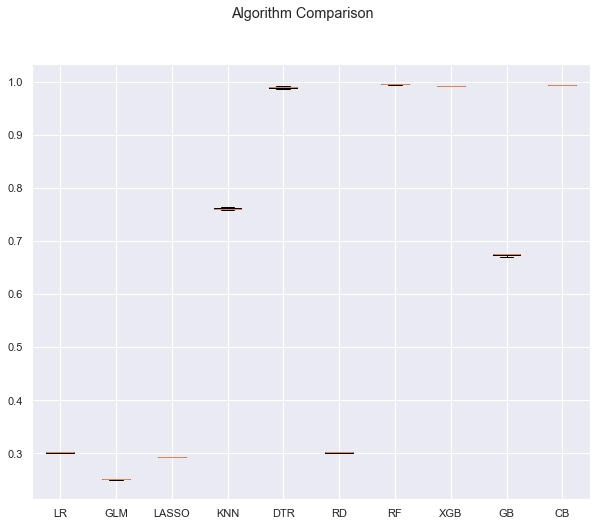


Evaluating for component:  rul_comp4

LR: 0.1954006778631359 (0.003502820125987555)
LR execution time (sec): 0.639976978302002
GLM: 0.16430326368423323 (0.0017662596083132948)
GLM execution time (sec): 0.2597801685333252
LASSO: 0.18540486369296585 (0.0029606770606198335)
LASSO execution time (sec): 0.2881350517272949
KNN: 0.736925863284659 (0.0010316846898257034)
KNN execution time (sec): 162.13919377326965
DTR: 0.991511102753079 (0.0012191110037419106)
DTR execution time (sec): 6.078207015991211
RD: 0.19540042480853428 (0.0034854990882860017)
RD execution time (sec): 0.1662919521331787
RF: 0.9953983327141005 (0.0006084684499893492)
RF execution time (sec): 370.3046259880066
XGB: 0.990129664873776 (9.402084467826272e-05)
XGB execution time (sec): 23.020707845687866
GB: 0.6783336680347448 (0.007101469118534339)
GB execution time (sec): 115.87248802185059
CB: 0.9928037985042956 (0.00026203480071941267)
CB execution time (sec): 19.046870946884155


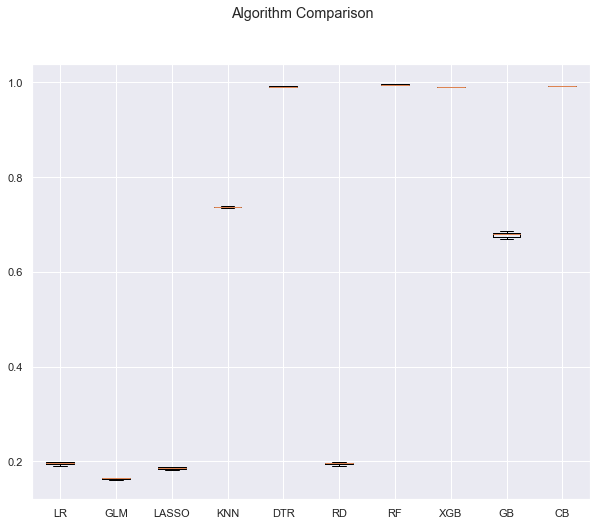

In [76]:
for rul_comp in cols_rul:

  print("Evaluating for component:  " + rul_comp)
  print()

  exec('y_temp = y_{}'.format(rul_comp))
  exec('X_temp = X_{}'.format(rul_comp))

  results = []
  names = []

  # Executing the function for every model in the list: models
  for name, model in models:
      # set start time
      start_time = time()

      # running algorithm
      run_cv_algorithm(name, model,X_temp, y_temp)


      # set end time: execution time
      exec_time = time() - start_time

      # Appending to the main list
      times.append(exec_time)

      print("{} execution time (sec): {}".format(name, exec_time))
    
    
  # boxplot algorithm comparison

  fig = plt.figure()
  fig.set_size_inches(10,8)
  fig.suptitle('Algorithm Comparison')
  ax = fig.add_subplot(111)
  plt.boxplot(results)
  ax.set_xticklabels(names)
  plt.show()

  print()

### Repeat for best models

In [78]:
# prepare models
models = []
models.append(('KNN', KNeighborsRegressor()))
models.append(('DTR', DecisionTreeRegressor()))
models.append(('RF', ensemble.RandomForestRegressor()))
models.append(('XGB', xgb.XGBRegressor(objective ='reg:linear', verbosity = 0)))
models.append(('GB', GradientBoostingRegressor()))
models.append(('CB', CatBoostRegressor(verbose=False)))

In [79]:
num_splits = 5

In [80]:
#Yeo-Johnson
df_yj, results_yj =run_cv_reg(models, X_yj, y, num_splits,evaluator='r2')
df_yj

Executing KNN...
CV finished for KNN and rul_comp1
CV finished for KNN and rul_comp2
CV finished for KNN and rul_comp3
CV finished for KNN and rul_comp4
Executing DTR...
CV finished for DTR and rul_comp1
CV finished for DTR and rul_comp2
CV finished for DTR and rul_comp3
CV finished for DTR and rul_comp4
Executing RF...
CV finished for RF and rul_comp1
CV finished for RF and rul_comp2
CV finished for RF and rul_comp3
CV finished for RF and rul_comp4
Executing XGB...
CV finished for XGB and rul_comp1
CV finished for XGB and rul_comp2
CV finished for XGB and rul_comp3
CV finished for XGB and rul_comp4
Executing GB...
CV finished for GB and rul_comp1
CV finished for GB and rul_comp2
CV finished for GB and rul_comp3
CV finished for GB and rul_comp4
Executing CB...
CV finished for CB and rul_comp1
CV finished for CB and rul_comp2
CV finished for CB and rul_comp3
CV finished for CB and rul_comp4


,model,component,min_r2_score,1st_quantile,median_r2_score,mean_r2_score,std_r2_score,3rd_quantile,max_r2_score,exec_time_sec,time_score_ratio
0,KNN,rul_comp1,0.7756,0.7787,0.7801,0.7835,0.0068,0.7899,0.7931,352.5890,0.0022
1,KNN,rul_comp2,0.7747,0.7752,0.7785,0.7782,0.0029,0.7808,0.7820,906.7000,0.0009
2,KNN,rul_comp3,0.7968,0.7984,0.8011,0.8007,0.0030,0.8019,0.8055,994.3782,0.0008
3,KNN,rul_comp4,0.7727,0.7750,0.7769,0.7777,0.0038,0.7803,0.7835,1184.6214,0.0007
4,DTR,rul_comp1,0.9930,0.9939,0.9945,0.9945,0.0011,0.9950,0.9963,16.3075,0.0610
5,DTR,rul_comp2,0.9941,0.9949,0.9955,0.9955,0.0010,0.9960,0.9970,38.7999,0.0257
6,DTR,rul_comp3,0.9879,0.9902,0.9909,0.9908,0.0018,0.9917,0.9934,46.4836,0.0213
7,DTR,rul_comp4,0.9907,0.9929,0.9932,0.9931,0.0013,0.9942,0.9943,58.2750,0.0170
8,RF,rul_comp1,0.9961,0.9965,0.9971,0.9971,0.0007,0.9977,0.9980,985.6987,0.0010
9,RF,rul_comp2,0.9969,0.9970,0.9979,0.9977,0.0007,0.9979,0.9986,2383.4791,0.0004


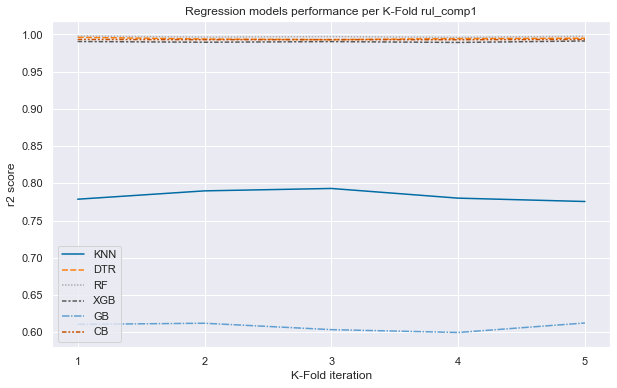

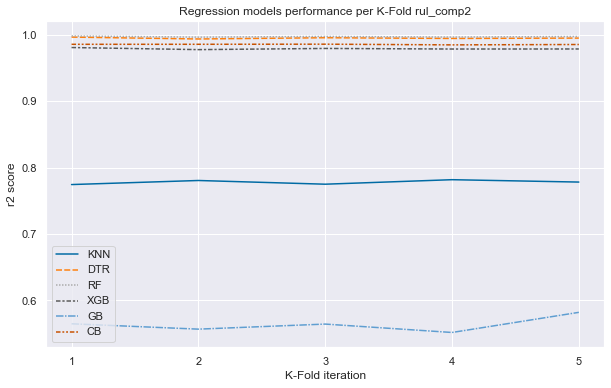

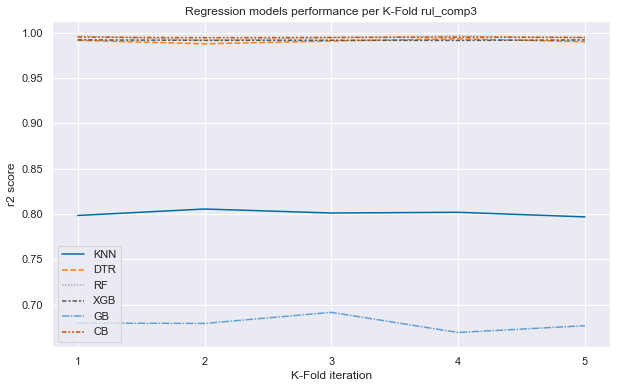

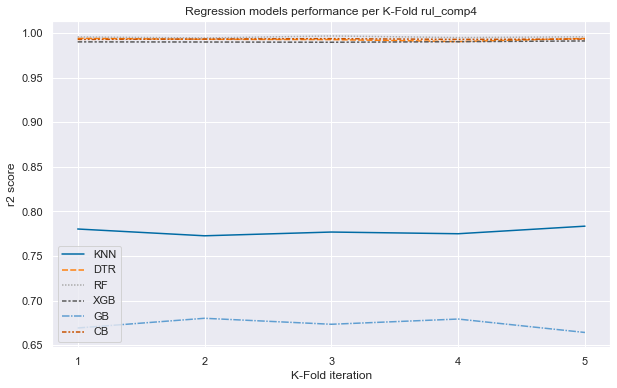

In [81]:
for rul_comp in cols_rul:
  plt.style.use('tableau-colorblind10')

  plt.figure(figsize=(10, 6))

  results_yj_comp = [results_yj[index] for index in list(df_yj[df_yj['component']== rul_comp].index)]
  sns.lineplot(data=results_yj_comp, dashes=True)

  plt.title(f'Regression models performance per K-Fold {rul_comp}')
  plt.xticks(list(range(0, results_yj_comp[0].shape[0])), list(range(1, (results_yj_comp[0].shape[0])+1)))
  plt.xlabel('K-Fold iteration')
  plt.ylabel('r2 score')

  plt.legend(df_yj[df_yj['component']== rul_comp].model.to_list())

  #plt.savefig('fig/08_models_cv.png')
  plt.show()

In [82]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha="center",
                    va="bottom")

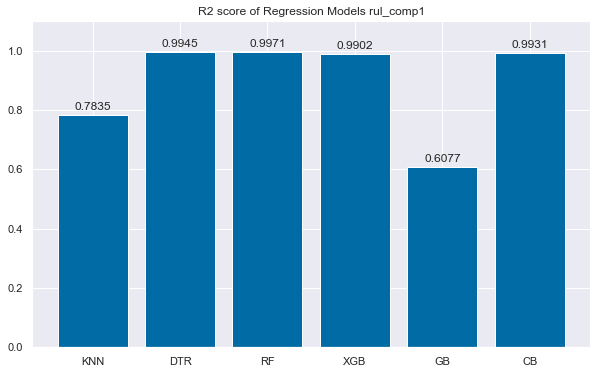

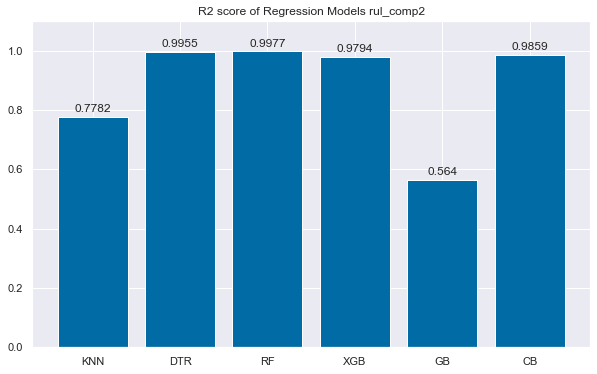

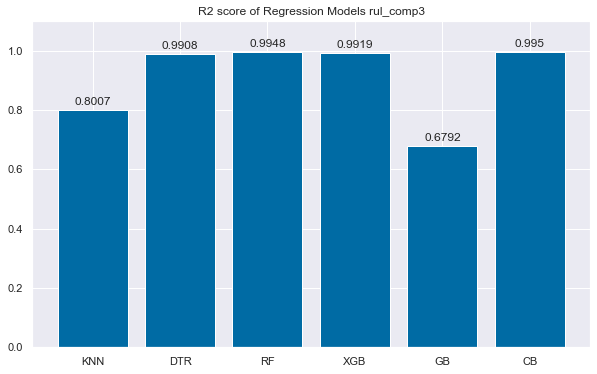

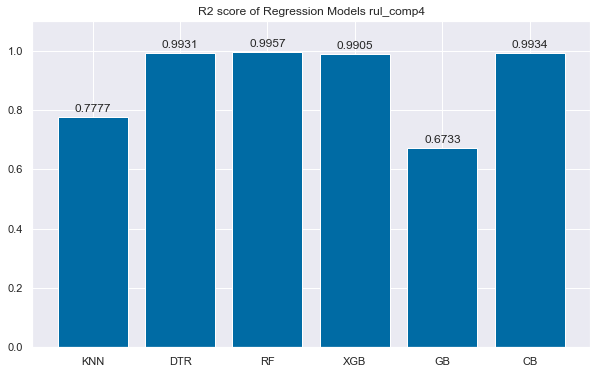

In [83]:
for rul_comp in cols_rul:

  df_yj_rul = df_yj[df_yj['component']==rul_comp]

  fig, ax = plt.subplots(figsize=(10,6))

  rect1 = ax.bar(df_yj_rul['model'], df_yj_rul['mean_r2_score'])

  plt.title(f'R2 score of Regression Models {rul_comp}')
  plt.gca().set_ylim([0, 1.1])

  autolabel(rect1)

  #plt.savefig('fig/08_models_mean_perf.png')
  plt.show()

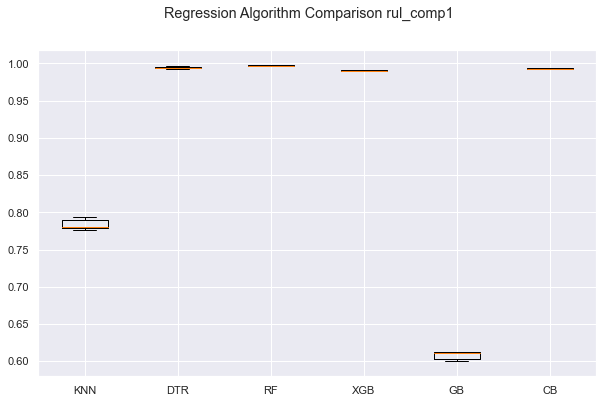

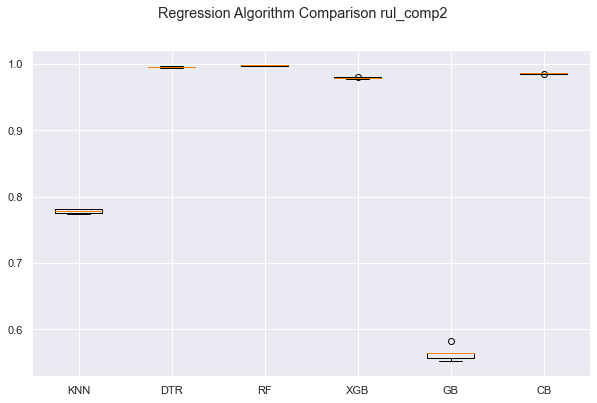

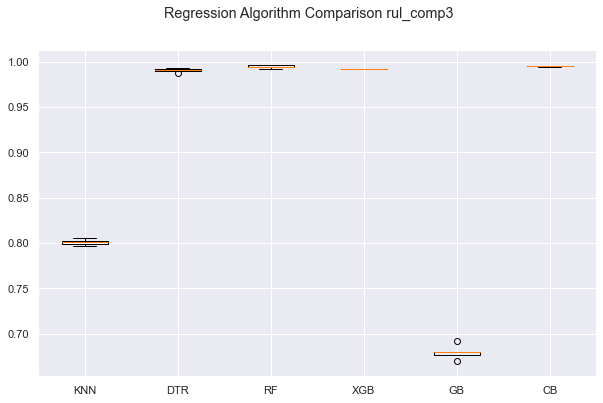

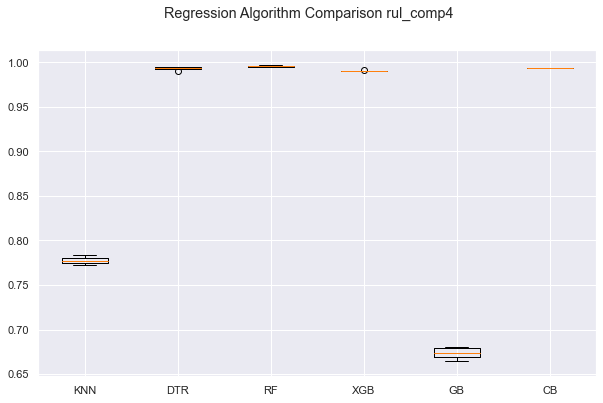

In [84]:
  for rul_comp in cols_rul:

    # boxplot algorithm comparison
    fig = plt.figure(figsize=(10,6))
    results_yj_comp = [results_yj[index] for index in list(df_yj[df_yj['component']== rul_comp].index)]

    fig.suptitle(f'Regression Algorithm Comparison {rul_comp}')

    ax = fig.add_subplot(111)
    plt.boxplot(results_yj_comp)
    ax.set_xticklabels(df_yj[df_yj['component']== rul_comp].model)

    #plt.savefig('fig/08_boxplot_all.png')
    plt.show()

# Conclusion

In terms of performance we have 3 clear winners:


1.   Decission trees
2.   Random forest
3.   CatBoost



Since the model will be put in production, it will be necessary also to consider the time taken for the algorithm to give a prediction. We created a ratio between the r2 mean score and the executing time to be able to cumpute the performance againts time. 

Hence we will select the CastBoost Regressor and tune the hyperparamenters to improve the performance.